In [1]:
import polars as pl
import numpy as np
from datetime import datetime, timezone, timedelta
from zoneinfo import ZoneInfo
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['timezone'] = 'Europe/Moscow'

import ast
import math
import pickle
from bot.utils.pair_trading import make_df_from_orderbooks, make_trunc_df, make_zscore_df
from bot.analysis.strategy_analysis import analyze_strategy, create_pair_trades_df
from bot.utils.coins import get_step_info, get_price_scale

from bot.core.db.postgres_manager import DBManager
from bot.config.credentials import host, user, password, db_name
db_params = {'host': host, 'user': user, 'password': password, 'dbname': db_name}
db_manager = DBManager(db_params)

from bot.utils.pair_trading import create_zscore_df, get_lr_zscore, get_dist_zscore, get_qty, round_down, calculate_profit_curve
from bot.utils.data import calculate_profit

with open("./data/coin_information.pkl", "rb") as f:
    coin_information = pickle.load(f)

In [2]:
trading_history = db_manager.get_table('trading_history', df_type='polars')

In [3]:
trading_history.sort(by='profit').head(3)

shape: (3, 18)
┌─────────┬─────────┬─────────┬─────────┬───┬─────────┬─────────┬─────────┬─────────┐
│ token_1 ┆ token_2 ┆ open_ti ┆ close_t ┆ … ┆ leverag ┆ pnl_1   ┆ pnl_2   ┆ profit  │
│ ---     ┆ ---     ┆ me      ┆ ime     ┆   ┆ e       ┆ ---     ┆ ---     ┆ ---     │
│ str     ┆ str     ┆ ---     ┆ ---     ┆   ┆ ---     ┆ f64     ┆ f64     ┆ f64     │
│         ┆         ┆ datetim ┆ datetim ┆   ┆ f64     ┆         ┆         ┆         │
│         ┆         ┆ e[μs,   ┆ e[μs,   ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ Europe/ ┆ Europe/ ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ Moscow] ┆ Moscow] ┆   ┆         ┆         ┆         ┆         │
╞═════════╪═════════╪═════════╪═════════╪═══╪═════════╪═════════╪═════════╪═════════╡
│ GRT     ┆ SEI     ┆ 2025-11 ┆ 2025-11 ┆ … ┆ 2.0     ┆ -21.199 ┆ 9.74561 ┆ -11.454 │
│         ┆         ┆ -07 08: ┆ -08 03: ┆   ┆         ┆ 753     ┆ 9       ┆ 134     │
│         ┆         ┆ 04:35   ┆ 01:08   ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ MSK     ┆ MSK     ┆   ┆         ┆         ┆         ┆         │
│ CELO    ┆ IMX     ┆ 2025-11 ┆ 2025-11 ┆ … ┆ 2.0     ┆ 7.34779 ┆ -15.019 ┆ -7.6713 │
│         ┆         ┆ -02 00: ┆ -04 01: ┆   ┆         ┆ 4       ┆ 162     ┆ 68      │
│         ┆         ┆ 44:29   ┆ 07:47   ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ MSK     ┆ MSK     ┆   ┆         ┆         ┆         ┆         │
│ IOTA    ┆ MOVE    ┆ 2025-11 ┆ 2025-11 ┆ … ┆ 2.0     ┆ 5.41190 ┆ -11.561 ┆ -6.1492 │
│         ┆         ┆ -04 03: ┆ -04 21: ┆   ┆         ┆ 8       ┆ 147     ┆ 38      │
│         ┆         ┆ 45:14   ┆ 33:06   ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ MSK     ┆ MSK     ┆   ┆         ┆         ┆         ┆         │
└─────────┴─────────┴─────────┴─────────┴───┴─────────┴─────────┴─────────┴─────────┘

In [4]:
trading_history['profit'].sum()

24.929752369999996

In [5]:
trading_history.group_by('token_1', 'token_2').agg(
    pl.col('profit').sum().round(2),
    pl.col('profit').min().round(2).alias('min_profit'),
    pl.col('profit').max().round(2).alias('max_profit'),
    (pl.col('profit').sum() / pl.col('profit').len()).round(2).alias('avg_profit'),
    pl.col('profit').len().alias('n_trades'),

).sort(by='profit', descending=True)

shape: (15, 7)
┌─────────┬─────────┬────────┬────────────┬────────────┬────────────┬──────────┐
│ token_1 ┆ token_2 ┆ profit ┆ min_profit ┆ max_profit ┆ avg_profit ┆ n_trades │
│ ---     ┆ ---     ┆ ---    ┆ ---        ┆ ---        ┆ ---        ┆ ---      │
│ str     ┆ str     ┆ f64    ┆ f64        ┆ f64        ┆ f64        ┆ u32      │
╞═════════╪═════════╪════════╪════════════╪════════════╪════════════╪══════════╡
│ OP      ┆ TIA     ┆ 9.56   ┆ 0.49       ┆ 5.34       ┆ 2.39       ┆ 4        │
│ ARKM    ┆ MANTA   ┆ 8.95   ┆ -0.83      ┆ 4.31       ┆ 1.79       ┆ 5        │
│ CVX     ┆ SUSHI   ┆ 7.81   ┆ 0.19       ┆ 4.4        ┆ 1.95       ┆ 4        │
│ CHZ     ┆ KAS     ┆ 6.3    ┆ -0.22      ┆ 6.52       ┆ 3.15       ┆ 2        │
│ MORPHO  ┆ STX     ┆ 5.48   ┆ 1.27       ┆ 4.2        ┆ 2.74       ┆ 2        │
│ …       ┆ …       ┆ …      ┆ …          ┆ …          ┆ …          ┆ …        │
│ CRV     ┆ SUI     ┆ -1.48  ┆ -5.76      ┆ 2.53       ┆ -0.49      ┆ 3        │
│ IOTA    ┆ MOVE    ┆ -3.02  ┆ -6.15      ┆ 2.96       ┆ -1.01      ┆ 3        │
│ CELO    ┆ IMX     ┆ -3.29  ┆ -7.67      ┆ 2.13       ┆ -0.82      ┆ 4        │
│ RENDER  ┆ XRP     ┆ -3.7   ┆ -4.12      ┆ 0.42       ┆ -1.85      ┆ 2        │
│ GRT     ┆ SEI     ┆ -8.1   ┆ -11.45     ┆ 1.69       ┆ -2.02      ┆ 4        │
└─────────┴─────────┴────────┴────────────┴────────────┴────────────┴──────────┘

In [6]:
def create_report(token_1: str,
                  token_2: str,
                  tf: str,
                  wind: int,
                  thresh_in: float,
                  thresh_out: float,
                  open_time: datetime,
                  close_time: datetime,
                  spread_method: str,
                  min_order: int,
                  sl_ratio: float,
                  fee_rate: float,
                  coin_information: dict,
                  plot: bool=True):

    open_ts = int(datetime.timestamp(open_time))
    close_ts = int(datetime.timestamp(close_time))
    winds = np.array((wind, ))

    trading_history = db_manager.get_table('trading_history', df_type='polars')
    z_score_hist = db_manager.get_zscore_history(token_1 + '_USDT', token_2 + '_USDT', open_ts, close_ts)
    stats = pl.read_parquet('./data/curr_pairs.parquet').filter(
                (pl.col('coin1') == token_1) & (pl.col('coin2') == token_2) | 
                (pl.col('coin1') == token_2) & (pl.col('coin2') == token_1)
            )
    data = trading_history.filter(
            (pl.col('token_1') == token_1) & (pl.col('token_2') == token_2) & 
            (abs(pl.col('open_time') - open_time) < timedelta(seconds=10))
        )

    side_1 = data['side_1'][0]
    side_2 = data['side_2'][0]
    leverage = int(data['leverage'][0])
    median_length = 4

    # Реальный размер позиции
    t1_qty = data['qty_1'][0]
    t2_qty = data['qty_2'][0]

    t1_op_real = data['open_price_1'][0]
    t2_op_real = data['open_price_2'][0]
    t1_cp_real = data['close_price_1'][0]
    t2_cp_real = data['close_price_2'][0]

    t1_profit = data['pnl_1'][0]
    t2_profit = data['pnl_2'][0]
    total_profit = t1_profit + t2_profit

    # vol-neutral
    total_pos_side = round(t1_qty * t1_op_real + t2_qty * t2_op_real)
    std_1 = stats['std_1'][0]
    std_2 = stats['std_2'][0]

    t1_qty_vn, t2_qty_vn = get_qty(token_1, token_2, t1_op_real, t2_op_real, beta=None, coin_information=coin_information,
                        total_usdt_amount=total_pos_side, fee_rate=fee_rate, std_1=std_1, std_2=std_2, method='vol_neutral')

    t1_profit_vn = calculate_profit(t1_op_real, t1_cp_real, t1_qty_vn, side_1)
    t2_profit_vn = calculate_profit(t2_op_real, t2_cp_real, t2_qty_vn, side_2)

    profit_vn = t1_profit_vn + t2_profit_vn

    # beta-neutral
    beta = stats['beta_2'][0]
    t1_qty_bn, t2_qty_bn = get_qty(token_1, token_2, t1_op_real, t2_op_real, beta, coin_information=coin_information,
                        total_usdt_amount=total_pos_side, fee_rate=fee_rate, method='beta_neutral')
    t1_profit_bn = calculate_profit(t1_op_real, t1_cp_real, t1_qty_bn, side_1)
    t2_profit_bn = calculate_profit(t2_op_real, t2_cp_real, t2_qty_bn, side_2)

    profit_bn = t1_profit_bn + t2_profit_bn

    if plot:
        train_len = int(tf[0]) * wind * 2
        start_time = open_time - timedelta(hours = train_len)

        df_1 = db_manager.get_tick_ob(token=token_1 + '_USDT', start_time=start_time, end_time=close_time)
        df_2 = db_manager.get_tick_ob(token=token_2 + '_USDT', start_time=start_time, end_time=close_time)
        avg_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time)

        if tf == '1h':
            agg_df = make_trunc_df(avg_df, timeframe='1h', token_1=token_1, token_2=token_2, method='triple')
        elif tf == '4h':
            agg_df = make_trunc_df(avg_df, timeframe='4h', token_1=token_1, token_2=token_2, method='triple', offset='3h')

        tick_df = make_df_from_orderbooks(df_1, df_2, token_1, token_2, start_time=start_time)
        spread_df = create_zscore_df(token_1, token_2, tick_df, agg_df, tf, winds, min_order, open_ts, median_length)

        df = spread_df.select('time', 'ts', token_1, token_2, f'{token_1}_size', f'{token_2}_size',
             f'{token_1}_bid_price', f'{token_1}_ask_price', f'{token_1}_bid_size', f'{token_1}_ask_size',
             f'{token_2}_bid_price', f'{token_2}_ask_price', f'{token_2}_bid_size', f'{token_2}_ask_size',
             f'z_score_{wind}_{tf}').filter(
                (pl.col('time') >= start_time) & (pl.col('time') <= close_time)
             ).rename({f'z_score_{wind}_{tf}': 'z_score'})

        sl_profit = None
        if sl_ratio:
            pos_size = (t1_qty * t1_op_real + t2_qty * t2_op_real) / leverage
            sl_idx = z_score_hist.filter(pl.col('profit') < -sl_ratio * pos_size).head(1)

            if sl_idx.height > 0:
                sl_row = df.filter((m:=(pl.col('ts') - sl_idx['ts'][0]).abs()).min() == m)
                sl_time = sl_row['time'][0]
                t1_sl_close = sl_row[f'{token_1}_ask_price'][0] if side_1 == 'short' else sl_row[f'{token_1}_bid_price'][0]
                t2_sl_close = sl_row[f'{token_2}_bid_price'][0] if side_1 == 'short' else sl_row[f'{token_2}_ask_price'][0]

                sl_pr_1 = calculate_profit(open_price=t1_op_real, close_price=t1_sl_close, n_coins=t1_qty, side=side_1)
                sl_pr_2 = calculate_profit(open_price=t2_op_real, close_price=t2_sl_close, n_coins=t2_qty, side=side_2)
                sl_profit = sl_pr_1 + sl_pr_2

        coef = df[token_1].mean() / df[token_2].mean()
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(14, 6), sharex=True)

        # --- Графики цены ---
        ax1.plot(df.select('time'), df.select(token_1), label=token_1, color='orange')
        ax1.set_title(f'{token_1} - {token_2} (tf: {tf}, wind: {wind}, side: {side_1}; thresh_in: {thresh_in}, thresh_out: {thresh_out})')
        ax1.set_ylabel('udst')
        ax1.legend()
        ax1.grid()

        ax4 = ax1.twinx()
        ax4.plot(df.select('time'), df.select(token_2), label=token_2, color='blue')

        # --- Графики z_score ---
        ax2.plot(df.select('time'), df.select('z_score'), label=f'calculated_z_score')
        ax2.plot(z_score_hist.select('time'), z_score_hist.select('z_score'), label=f'real_z_score')
        ax2.set_ylabel('z_score')
        if side_1 == 'long':
            ax2.axhline(-thresh_in, c='g', linestyle='dotted')
            ax2.axhline(thresh_out, c='r', linestyle='dotted')
        else:
            ax2.axhline(thresh_in, c='g', linestyle='dotted')
            ax2.axhline(-thresh_out, c='r', linestyle='dotted')
        ax2.grid()
        ax2.legend()

        # --- График профита ---
        ax3.plot(z_score_hist.select('time'), z_score_hist.select('profit'), color='green', label='profit')
        ax3.set_ylabel('profit')
        ax3.grid()
        ax3.legend()

        plt.tight_layout()
        plt.show()

    print(f'{token_1} - {token_2}. Side: {side_1}; Timeframe: {tf}; window: {wind}; thresh_in: {thresh_in}, thresh_out: {thresh_out}')
    print(f'[ OPEN] Время: {open_time:%Y-%m-%d %H:%M:%S}; Цены. {token_1}: {t1_op_real}; {token_2}: {t2_op_real};', end=' ')
    print(f'z_score: {z_score_hist['z_score'][0]:.2f}; Std: {token_1}: {std_1:.4f}; {token_2}: {std_2:.4f}')
    print(f'[CLOSE] Время: {close_time:%Y-%m-%d %H:%M:%S}; Цены. {token_1}: {t1_cp_real}; {token_2}: {t2_cp_real}; z_score: {z_score_hist['z_score'][-1]:.2f}')
    print()
    print(f'[PROFIT]')
    print(f'usdt-neutral: {t1_qty} {token_1}({side_1}): {t1_profit:.2f}$, {t2_qty} {token_2}({side_2}): {t2_profit:.2f}$; total profit: {total_profit:.2f}$')
    print(f'vol-neutral : {t1_qty_vn} {token_1}({side_1}): {t1_profit_vn:.2f}$, {t2_qty_vn} {token_2}({side_2}): {t2_profit_vn:.2f}$; total profit: {profit_vn:.2f}$')
    print(f'beta-neutral: {t1_qty_bn} {token_1}({side_1}): {t1_profit_bn:.2f}$, {t2_qty_bn} {token_2}({side_2}): {t2_profit_bn:.2f}$; total profit: {profit_bn:.2f}$')

    if sl_profit:
        print(f'\n[STOP LOSS] Время создания ордера: {sl_time:%Y-%m-%d %H:%M:%S}')
        print(f'Stop-loss. Цены. {token_1}: {t1_sl_close}; {token_2}: {t2_sl_close}')
        print(f'Profit: {token_1}({side_1}): {sl_pr_1:.2f}$, {token_2}({side_2}): {sl_pr_2:.2f}$; total profit: {sl_profit:.2f}$')

    if sl_profit:
        return sl_profit
    else:
        return total_profit, profit_vn, profit_bn

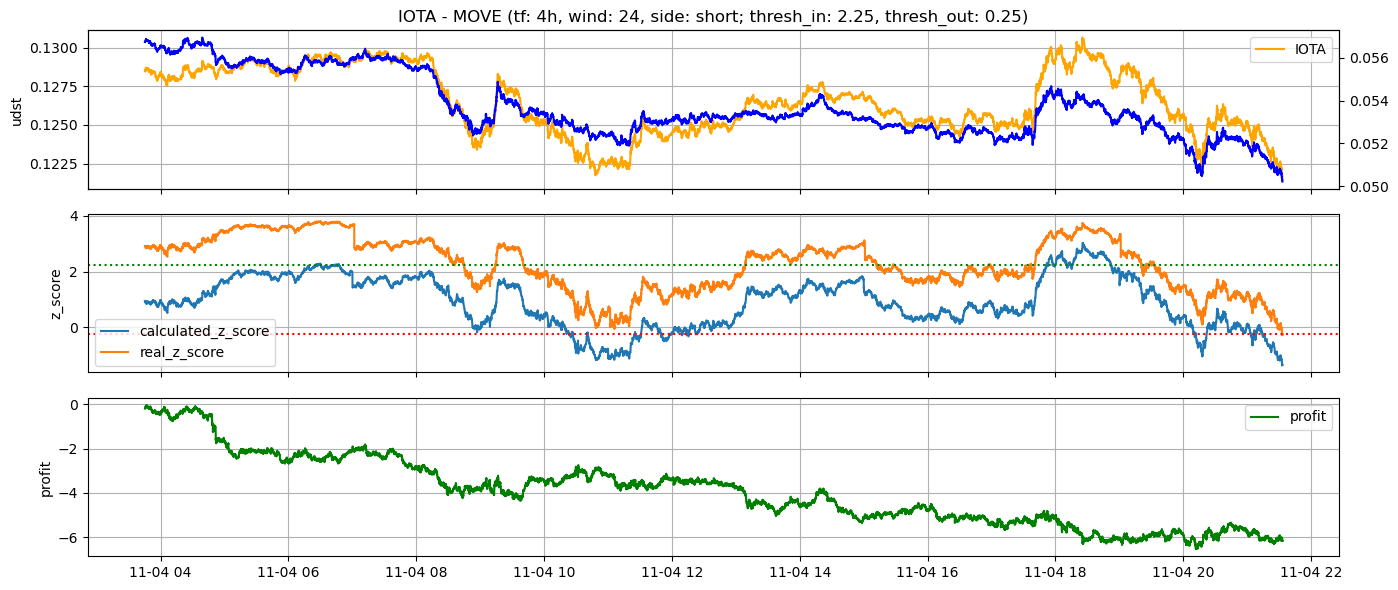

IOTA - MOVE. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-04 03:45:14; Цены. IOTA: 0.1286; MOVE: 0.05674; z_score: 2.92; Std: IOTA: 0.0272; MOVE: 0.0344
[CLOSE] Время: 2025-11-04 21:33:06; Цены. IOTA: 0.1215; MOVE: 0.05023; z_score: -0.27

[PROFIT]
usdt-neutral: 777.3 IOTA(short): 5.41$, 1760.0 MOVE(long): -11.56$; total profit: -6.15$
vol-neutral : 866.4 IOTA(short): 6.03$, 1553.0 MOVE(long): -10.20$; total profit: -4.17$
beta-neutral: 1246.4 IOTA(short): 8.68$, 697.0 MOVE(long): -4.58$; total profit: 4.10$


In [10]:
# ""	""	 MSK	

token_1 = 'IOTA'
token_2 = 'MOVE'
start_time = "2025-11-04 03:45:14"
end_time = "2025-11-04 21:33:06"
tf = '4h'
wind = 24
thresh_in = 2.25
thresh_out = 0.25

open_time = datetime.strptime(start_time, '%Y-%m-%d %H:%M:%S').replace(tzinfo=ZoneInfo("Europe/Moscow"))
close_time = datetime.strptime(end_time, '%Y-%m-%d %H:%M:%S').replace(tzinfo=ZoneInfo("Europe/Moscow"))

profit, profit_vn, profit_bn = create_report(token_1, token_2, tf, wind, thresh_in, thresh_out, 
            open_time, close_time, spread_method='lr',
            sl_ratio=0.5, fee_rate=0.00055, coin_information=coin_information,
            min_order=40)

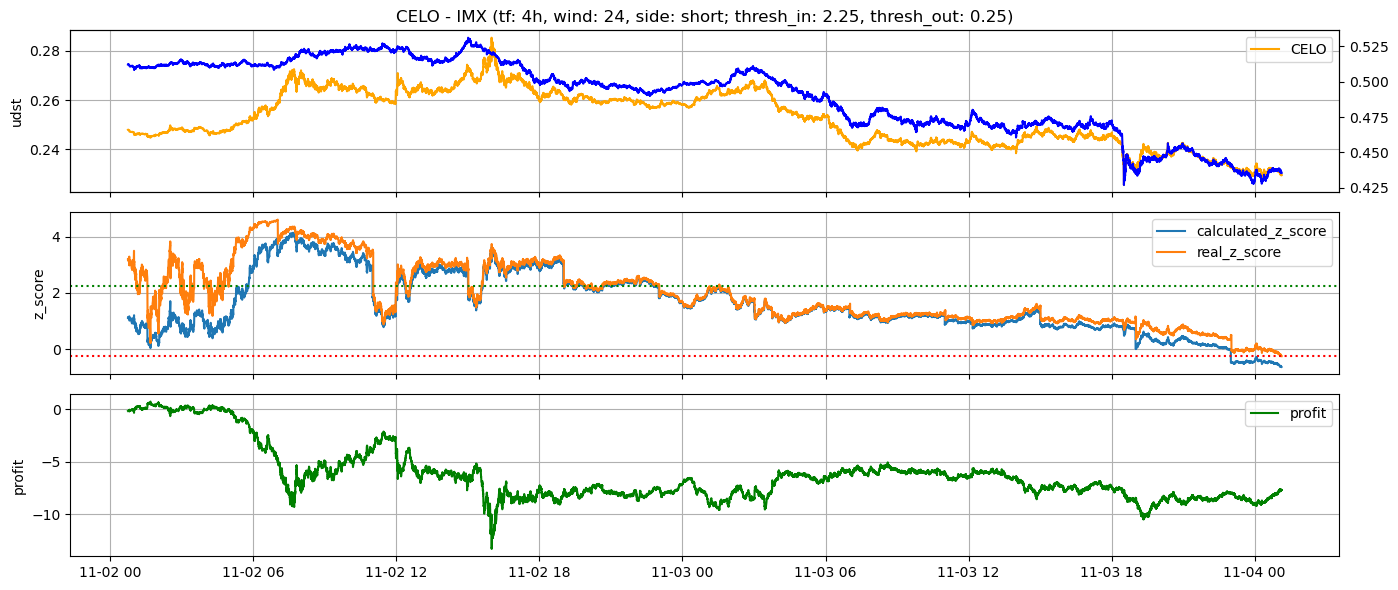

CELO - IMX. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-02 00:44:29; Цены. CELO: 0.2481; IMX: 0.5122; z_score: 3.19; Std: CELO: 0.0464; IMX: 0.1019
[CLOSE] Время: 2025-11-04 01:07:47; Цены. CELO: 0.2296; IMX: 0.4357; z_score: -0.25

[PROFIT]
usdt-neutral: 402.9 CELO(short): 7.35$, 195.0 IMX(long): -15.02$; total profit: -7.67$
vol-neutral : 552.6 CELO(short): 10.08$, 121.9 IMX(long): -9.39$; total profit: 0.69$
beta-neutral: 546.5 CELO(short): 9.97$, 125.4 IMX(long): -9.66$; total profit: 0.31$


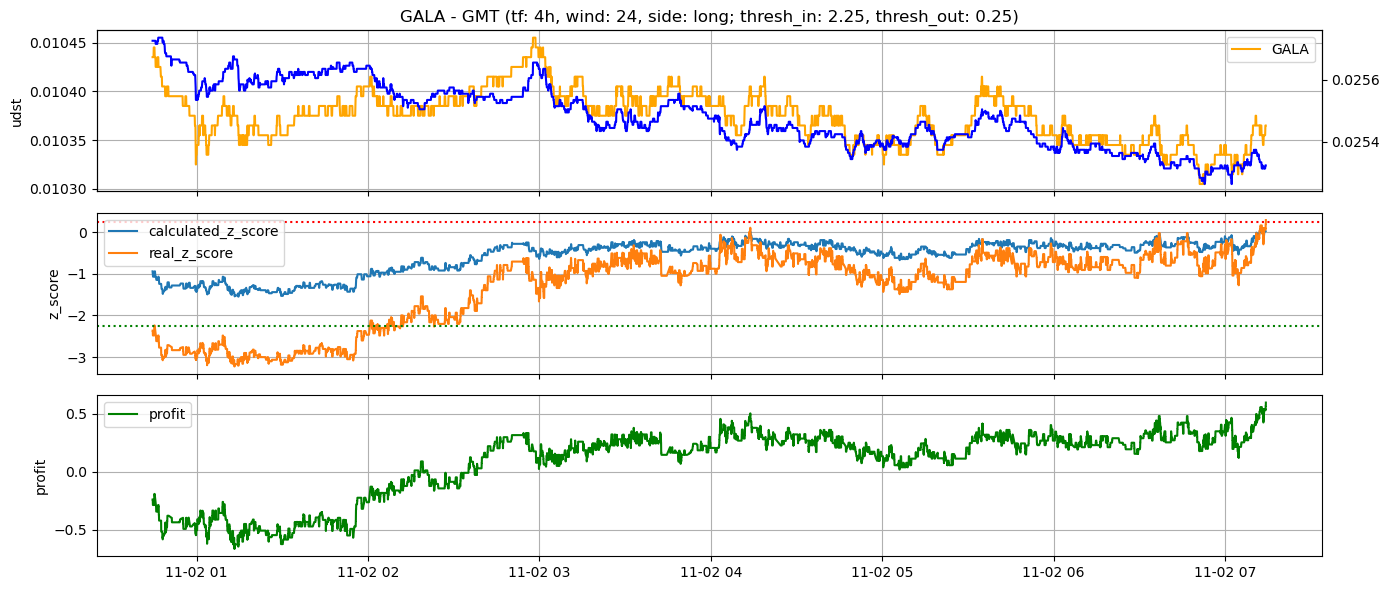

GALA - GMT. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-02 00:44:30; Цены. GALA: 0.01044; GMT: 0.02572; z_score: -2.36; Std: GALA: 0.0028; GMT: 0.0095
[CLOSE] Время: 2025-11-02 07:14:17; Цены. GALA: 0.01036; GMT: 0.02532; z_score: 0.29

[PROFIT]
usdt-neutral: 9568.0 GALA(long): -0.87$, 3883.0 GMT(short): 1.44$; total profit: 0.57$
vol-neutral : 14754.0 GALA(long): -1.35$, 1770.0 GMT(short): 0.66$; total profit: -0.69$
beta-neutral: 11481.0 GALA(long): -1.05$, 3110.0 GMT(short): 1.16$; total profit: 0.11$


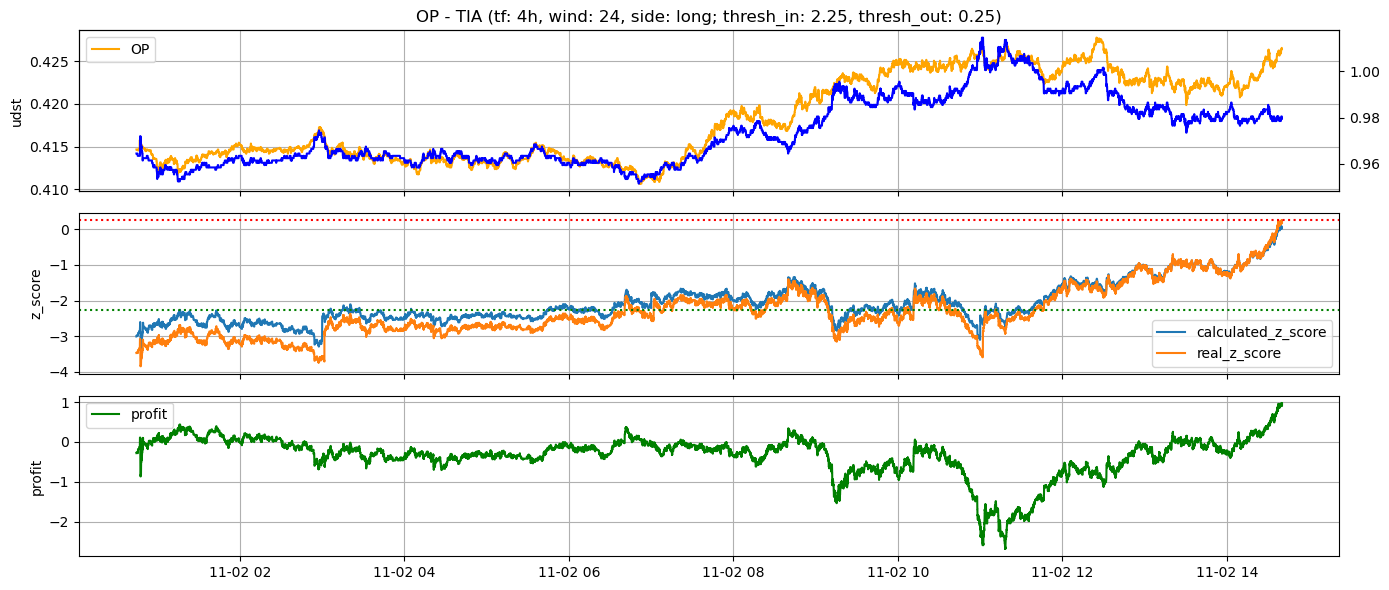

OP - TIA. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-02 00:44:30; Цены. OP: 0.4146; TIA: 0.964; z_score: -3.47; Std: OP: 0.1244; TIA: 0.4578
[CLOSE] Время: 2025-11-02 14:40:13; Цены. OP: 0.4265; TIA: 0.979; z_score: 0.19

[PROFIT]
usdt-neutral: 240.9 OP(long): 2.76$, 103.6 TIA(short): -1.66$; total profit: 1.09$
vol-neutral : 378.5 OP(long): 4.33$, 44.2 TIA(short): -0.71$; total profit: 3.62$
beta-neutral: 329.9 OP(long): 3.77$, 65.4 TIA(short): -1.05$; total profit: 2.72$
Ошибка с парой LDO - SAND



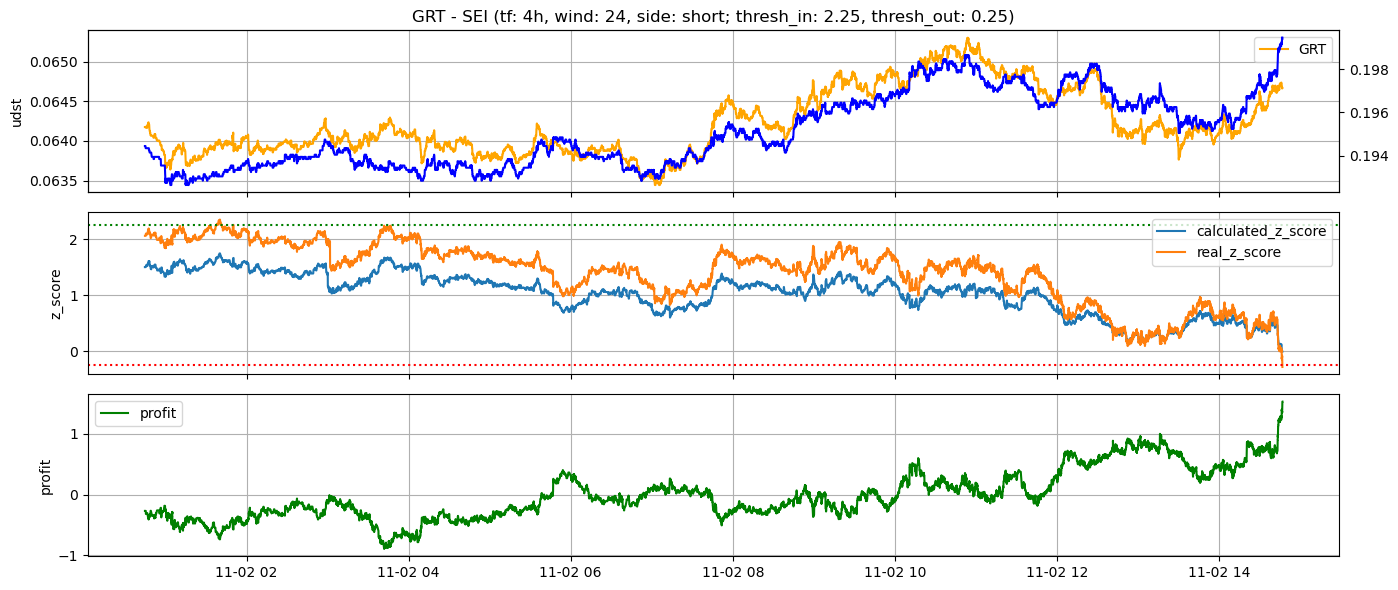

GRT - SEI. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-02 00:44:31; Цены. GRT: 0.06416; SEI: 0.1945; z_score: 2.06; Std: GRT: 0.0148; SEI: 0.0570
[CLOSE] Время: 2025-11-02 14:47:10; Цены. GRT: 0.06466; SEI: 0.1994; z_score: -0.28

[PROFIT]
usdt-neutral: 1556.6 GRT(short): -0.89$, 513.0 SEI(long): 2.40$; total profit: 1.51$
vol-neutral : 2469.3 GRT(short): -1.41$, 211.0 SEI(long): 0.99$; total profit: -0.42$
beta-neutral: 2196.3 GRT(short): -1.25$, 303.0 SEI(long): 1.42$; total profit: 0.17$


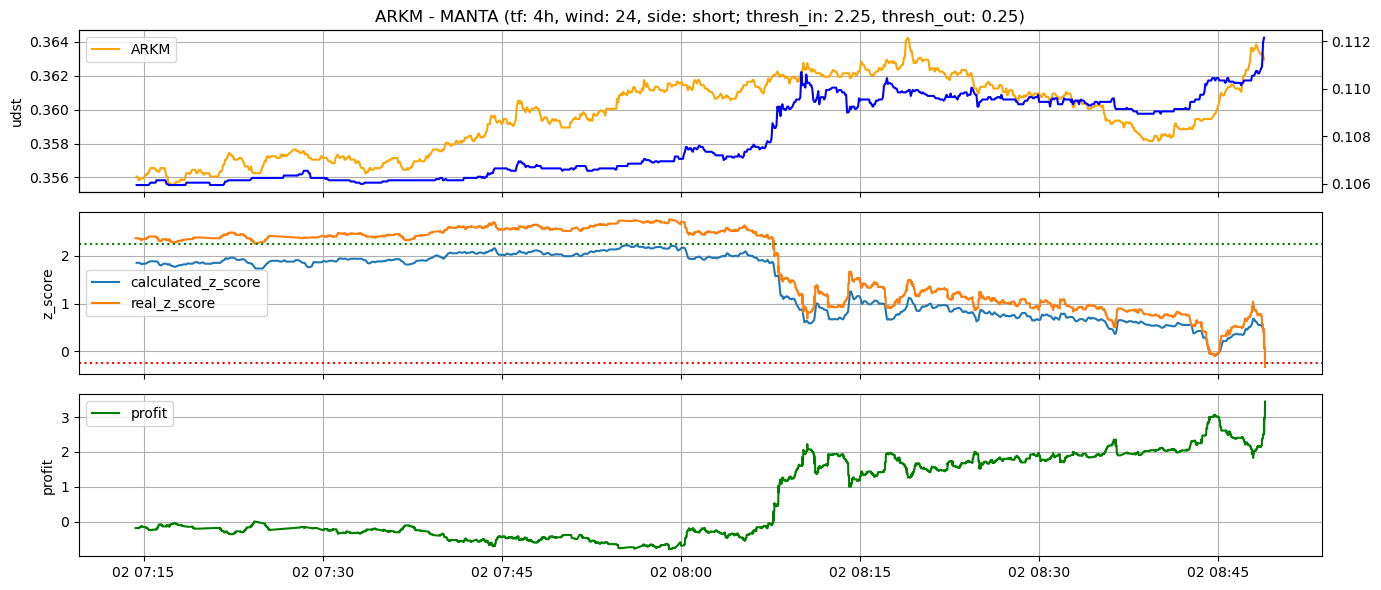

ARKM - MANTA. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-02 07:14:17; Цены. ARKM: 0.356; MANTA: 0.1059; z_score: 2.37; Std: ARKM: 0.0979; MANTA: 0.0506
[CLOSE] Время: 2025-11-02 08:48:56; Цены. ARKM: 0.3629; MANTA: 0.1122; z_score: -0.33

[PROFIT]
usdt-neutral: 280.0 ARKM(short): -2.04$, 942.3 MANTA(long): 5.82$; total profit: 3.78$
vol-neutral : 190.0 ARKM(short): -1.39$, 1235.8 MANTA(long): 7.64$; total profit: 6.25$
beta-neutral: 365.0 ARKM(short): -2.66$, 646.3 MANTA(long): 3.99$; total profit: 1.33$


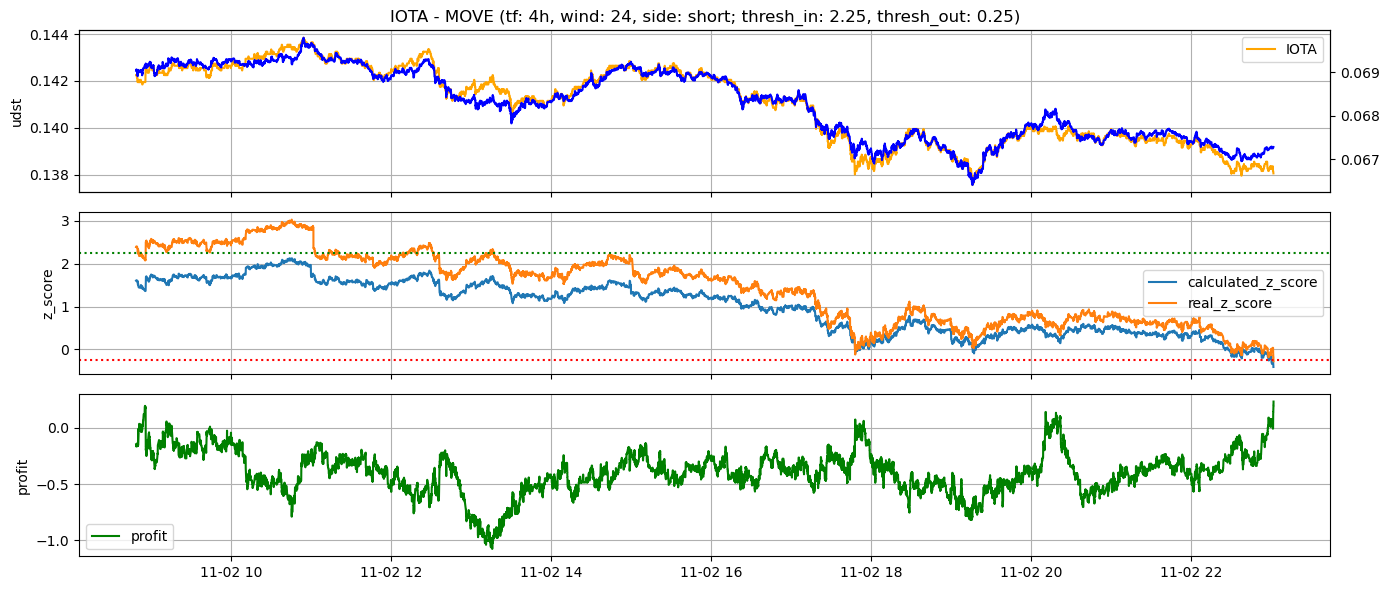

IOTA - MOVE. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-02 08:48:57; Цены. IOTA: 0.1423; MOVE: 0.06903; z_score: 2.39; Std: IOTA: 0.0272; MOVE: 0.0344
[CLOSE] Время: 2025-11-02 23:01:48; Цены. IOTA: 0.1381; MOVE: 0.06726; z_score: -0.28

[PROFIT]
usdt-neutral: 702.4 IOTA(short): 2.84$, 1446.0 MOVE(long): -2.67$; total profit: 0.17$
vol-neutral : 783.0 IOTA(short): 3.17$, 1276.0 MOVE(long): -2.35$; total profit: 0.81$
beta-neutral: 1104.7 IOTA(short): 4.47$, 618.0 MOVE(long): -1.14$; total profit: 3.33$


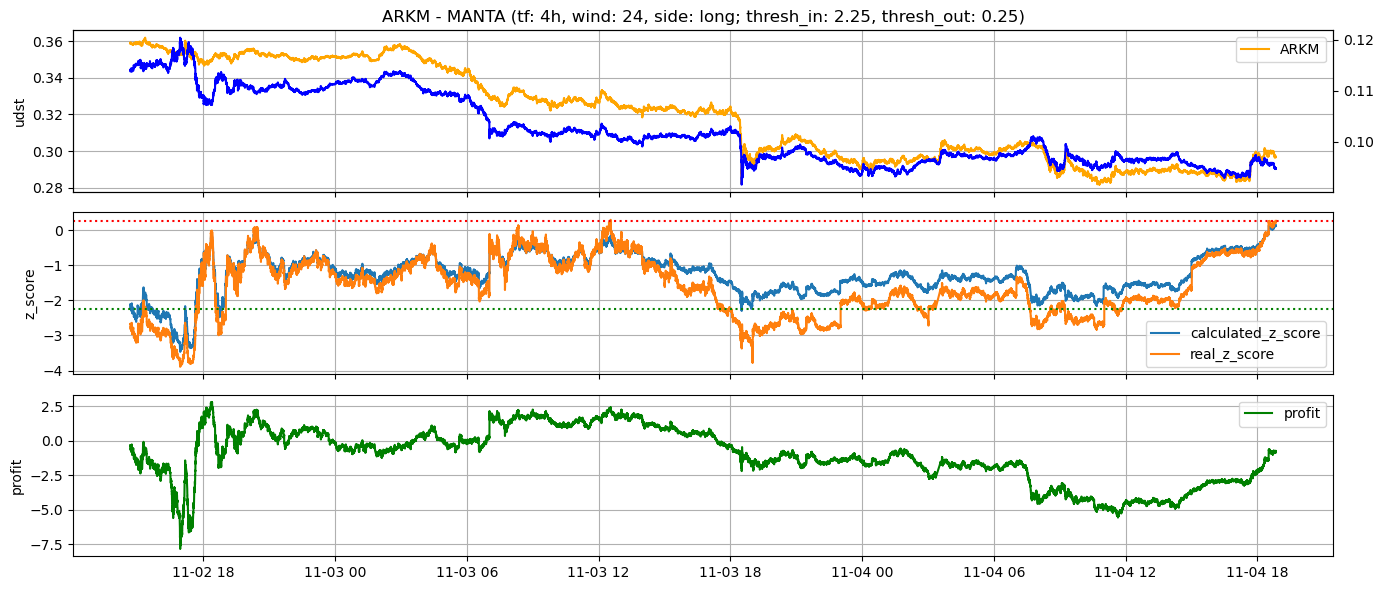

ARKM - MANTA. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-02 14:40:13; Цены. ARKM: 0.359; MANTA: 0.1138; z_score: -2.68; Std: ARKM: 0.0979; MANTA: 0.0506
[CLOSE] Время: 2025-11-04 18:50:59; Цены. ARKM: 0.2965; MANTA: 0.0947; z_score: 0.26

[PROFIT]
usdt-neutral: 278.0 ARKM(long): -17.48$, 876.9 MANTA(short): 16.65$; total profit: -0.83$
vol-neutral : 189.0 ARKM(long): -11.88$, 1155.8 MANTA(short): 21.94$; total profit: 10.06$
beta-neutral: 356.0 ARKM(long): -22.38$, 630.4 MANTA(short): 11.97$; total profit: -10.41$


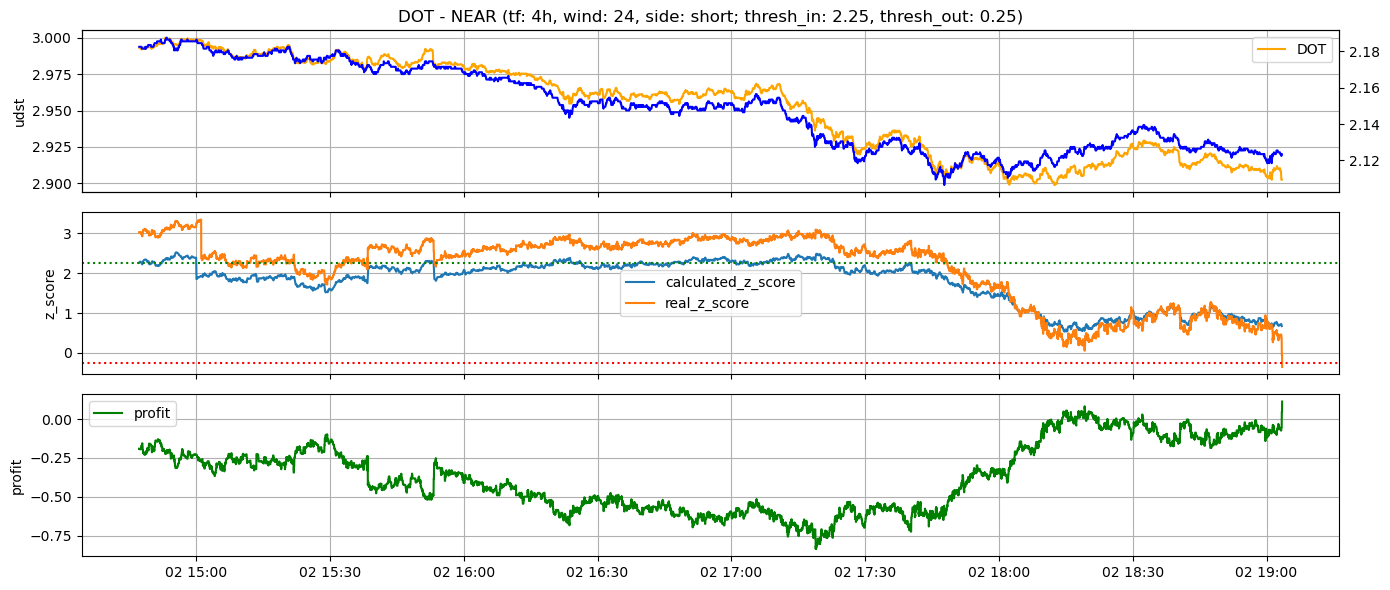

DOT - NEAR. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-02 14:47:10; Цены. DOT: 2.9932; NEAR: 2.182; z_score: 3.03; Std: DOT: 0.3033; NEAR: 0.5142
[CLOSE] Время: 2025-11-02 19:03:33; Цены. DOT: 2.9015; NEAR: 2.123; z_score: -0.35

[PROFIT]
usdt-neutral: 32.1 DOT(short): 2.84$, 44.0 NEAR(long): -2.70$; total profit: 0.14$
vol-neutral : 40.2 DOT(short): 3.56$, 32.5 NEAR(long): -1.99$; total profit: 1.56$
beta-neutral: 47.5 DOT(short): 4.20$, 22.7 NEAR(long): -1.39$; total profit: 2.81$


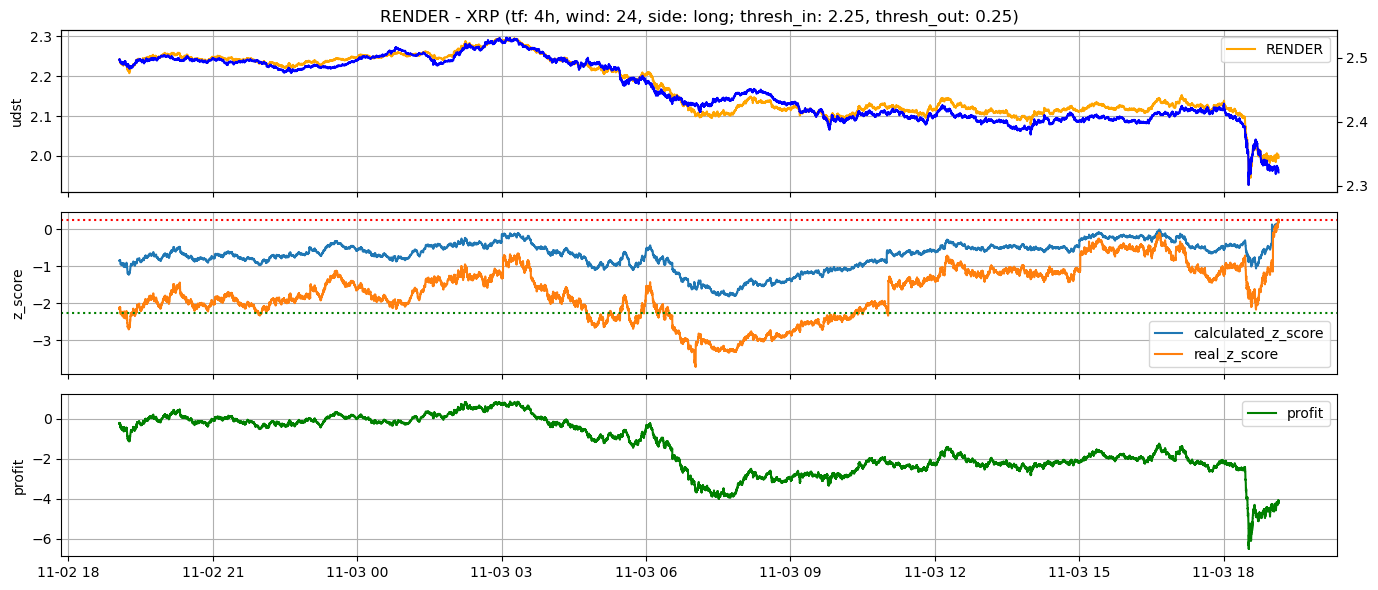

RENDER - XRP. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-02 19:03:33; Цены. RENDER: 2.242; XRP: 2.4966; z_score: -2.14; Std: RENDER: 0.6717; XRP: 0.3897
[CLOSE] Время: 2025-11-03 19:08:23; Цены. RENDER: 1.996; XRP: 2.3207; z_score: 0.25

[PROFIT]
usdt-neutral: 44.5 RENDER(long): -11.05$, 40.0 XRP(short): 6.93$; total profit: -4.12$
vol-neutral : 32.6 RENDER(long): -8.10$, 50.5 XRP(short): 8.75$; total profit: 0.65$
beta-neutral: 52.2 RENDER(long): -12.96$, 33.0 XRP(short): 5.72$; total profit: -7.25$
Ошибка с парой CVX - SUSHI



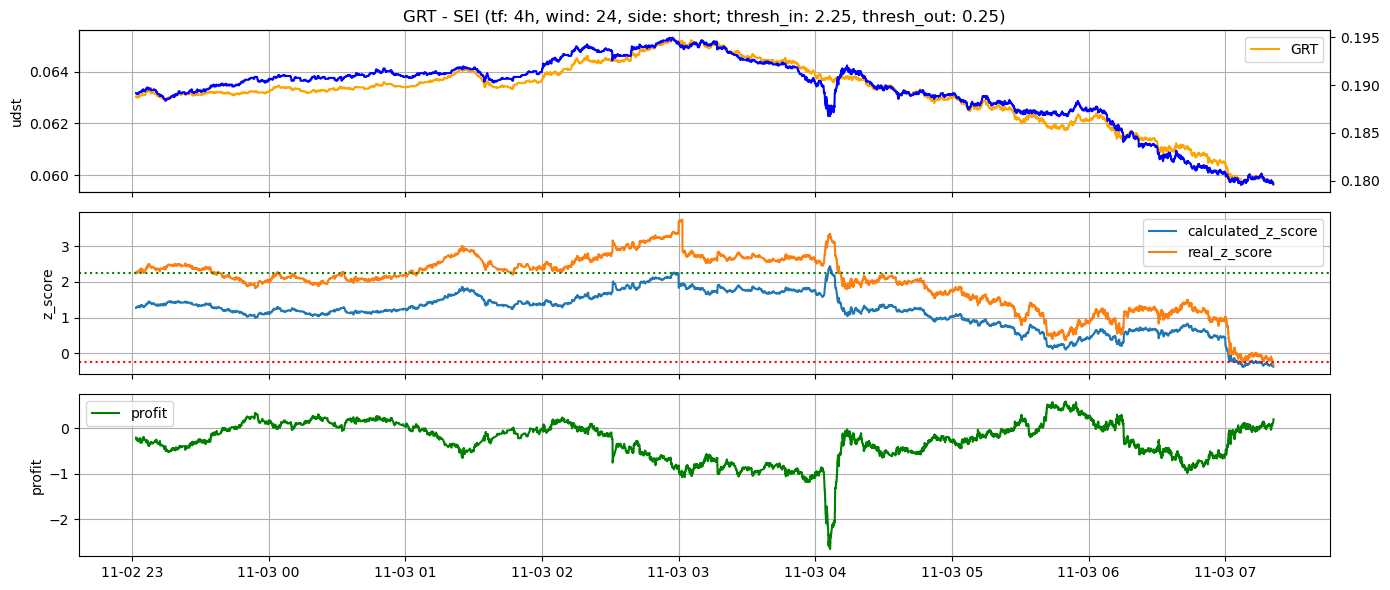

GRT - SEI. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-02 23:01:48; Цены. GRT: 0.06303; SEI: 0.1892; z_score: 2.24; Std: GRT: 0.0148; SEI: 0.0570
[CLOSE] Время: 2025-11-03 07:21:14; Цены. GRT: 0.05964; SEI: 0.1797; z_score: -0.35

[PROFIT]
usdt-neutral: 1584.8 GRT(short): 5.27$, 527.0 SEI(long): -5.11$; total profit: 0.15$
vol-neutral : 2513.5 GRT(short): 8.35$, 217.0 SEI(long): -2.11$; total profit: 6.25$
beta-neutral: 2242.1 GRT(short): 7.45$, 309.0 SEI(long): -3.00$; total profit: 4.45$


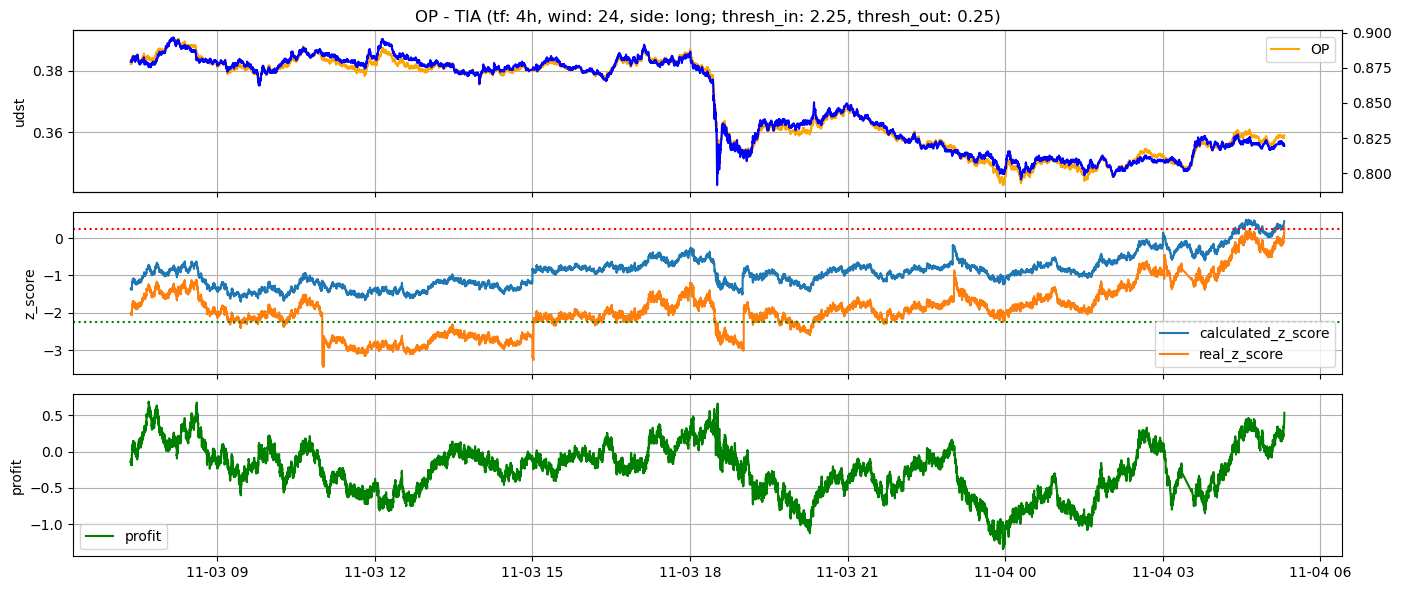

OP - TIA. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-03 07:21:15; Цены. OP: 0.3823; TIA: 0.88; z_score: -2.01; Std: OP: 0.1244; TIA: 0.4578
[CLOSE] Время: 2025-11-04 05:18:48; Цены. OP: 0.3589; TIA: 0.82; z_score: 0.27

[PROFIT]
usdt-neutral: 261.2 OP(long): -6.22$, 113.6 TIA(short): 6.71$; total profit: 0.49$
vol-neutral : 410.4 OP(long): -9.77$, 48.4 TIA(short): 2.86$; total profit: -6.91$
beta-neutral: 358.9 OP(long): -8.54$, 71.2 TIA(short): 4.21$; total profit: -4.34$


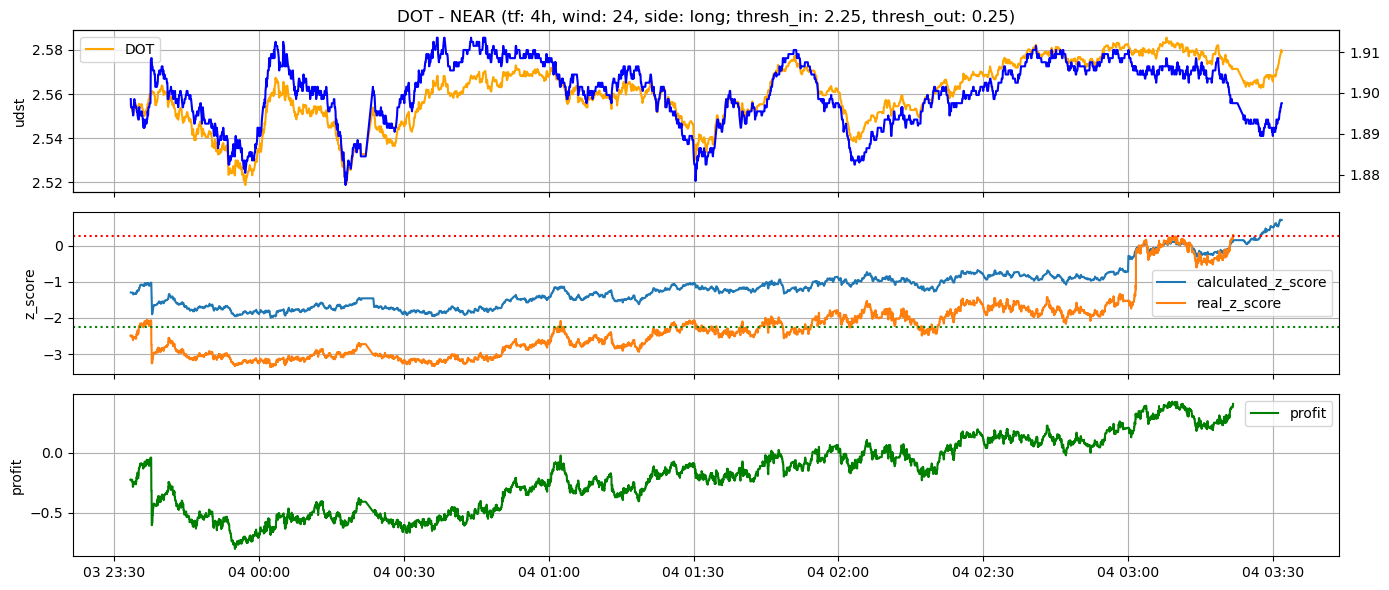

DOT - NEAR. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-03 23:33:21; Цены. DOT: 2.5546; NEAR: 1.897; z_score: -2.50; Std: DOT: 0.3033; NEAR: 0.5142
[CLOSE] Время: 2025-11-04 03:31:58; Цены. DOT: 2.5786; NEAR: 1.897; z_score: 0.29

[PROFIT]
usdt-neutral: 39.0 DOT(long): 0.83$, 52.6 NEAR(short): -0.11$; total profit: 0.72$
vol-neutral : 48.8 DOT(long): 1.03$, 38.8 NEAR(short): -0.08$; total profit: 0.95$
beta-neutral: 57.4 DOT(long): 1.22$, 27.5 NEAR(short): -0.06$; total profit: 1.16$


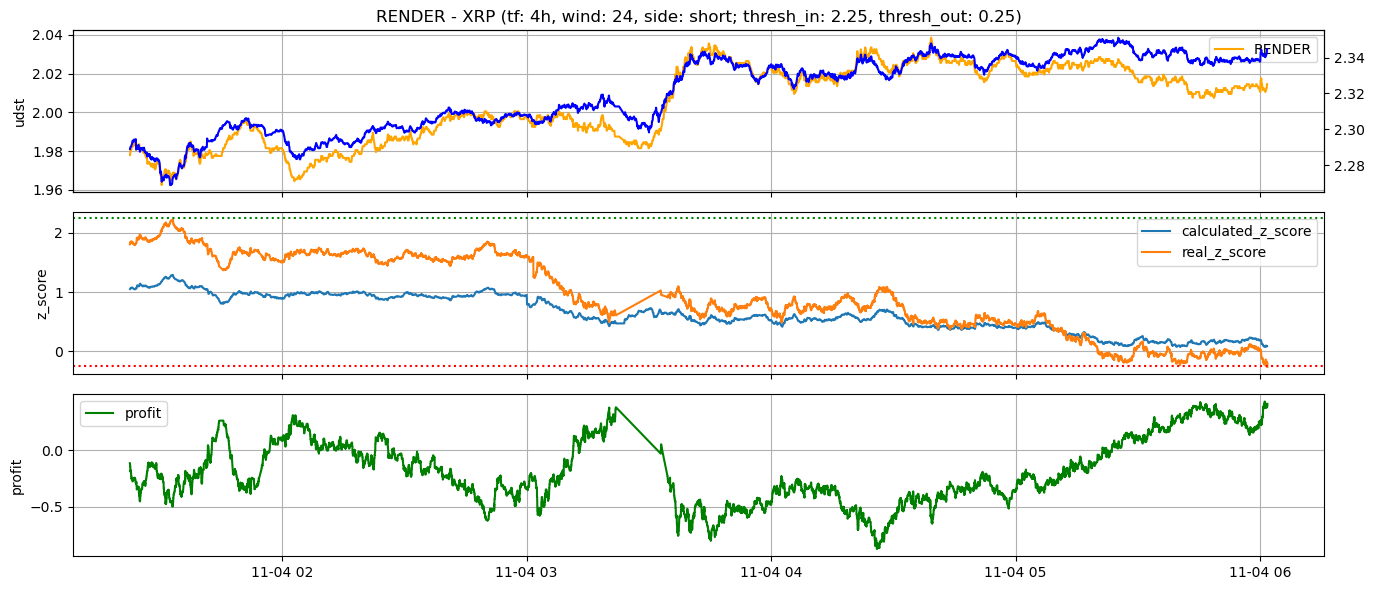

RENDER - XRP. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-04 01:22:35; Цены. RENDER: 1.978; XRP: 2.288; z_score: 1.80; Std: RENDER: 0.6717; XRP: 0.3897
[CLOSE] Время: 2025-11-04 06:01:48; Цены. RENDER: 2.014; XRP: 2.3445; z_score: -0.26

[PROFIT]
usdt-neutral: 50.5 RENDER(short): -1.93$, 43.6 XRP(long): 2.35$; total profit: 0.42$
vol-neutral : 37.0 RENDER(short): -1.41$, 55.1 XRP(long): 2.97$; total profit: 1.56$
beta-neutral: 58.3 RENDER(short): -2.23$, 36.9 XRP(long): 1.99$; total profit: -0.24$


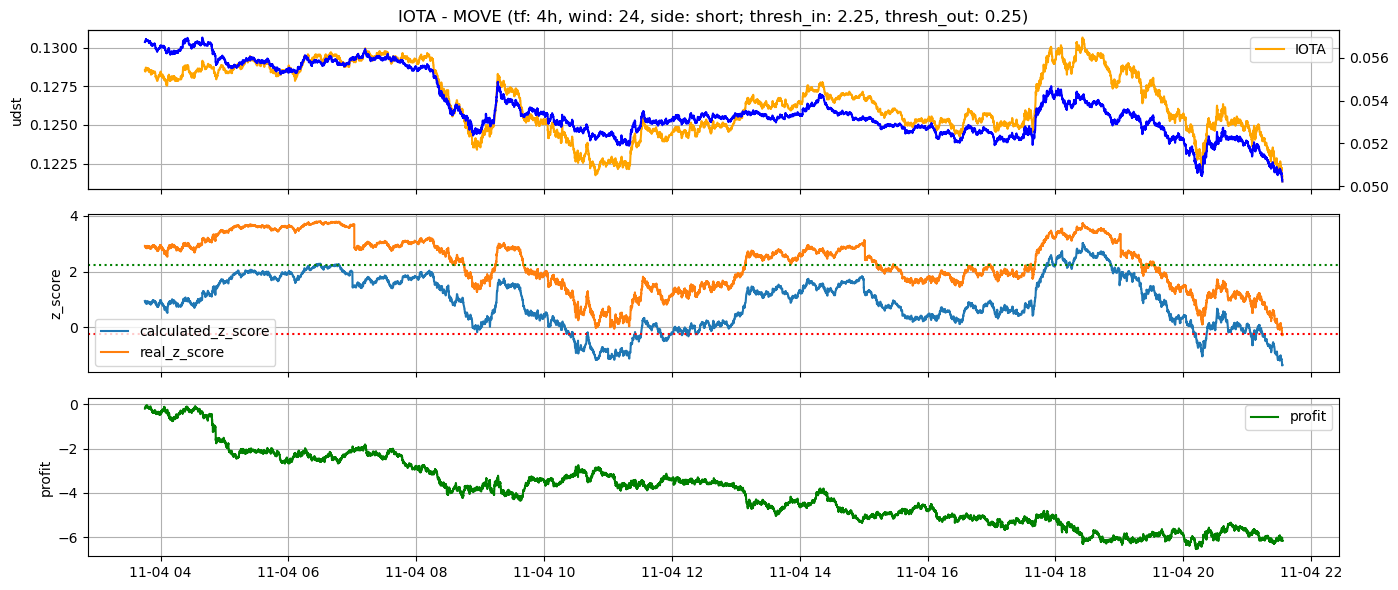

IOTA - MOVE. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-04 03:45:14; Цены. IOTA: 0.1286; MOVE: 0.05674; z_score: 2.92; Std: IOTA: 0.0272; MOVE: 0.0344
[CLOSE] Время: 2025-11-04 21:33:06; Цены. IOTA: 0.1215; MOVE: 0.05023; z_score: -0.27

[PROFIT]
usdt-neutral: 777.3 IOTA(short): 5.41$, 1760.0 MOVE(long): -11.56$; total profit: -6.15$
vol-neutral : 866.4 IOTA(short): 6.03$, 1553.0 MOVE(long): -10.20$; total profit: -4.17$
beta-neutral: 1246.4 IOTA(short): 8.68$, 697.0 MOVE(long): -4.58$; total profit: 4.10$


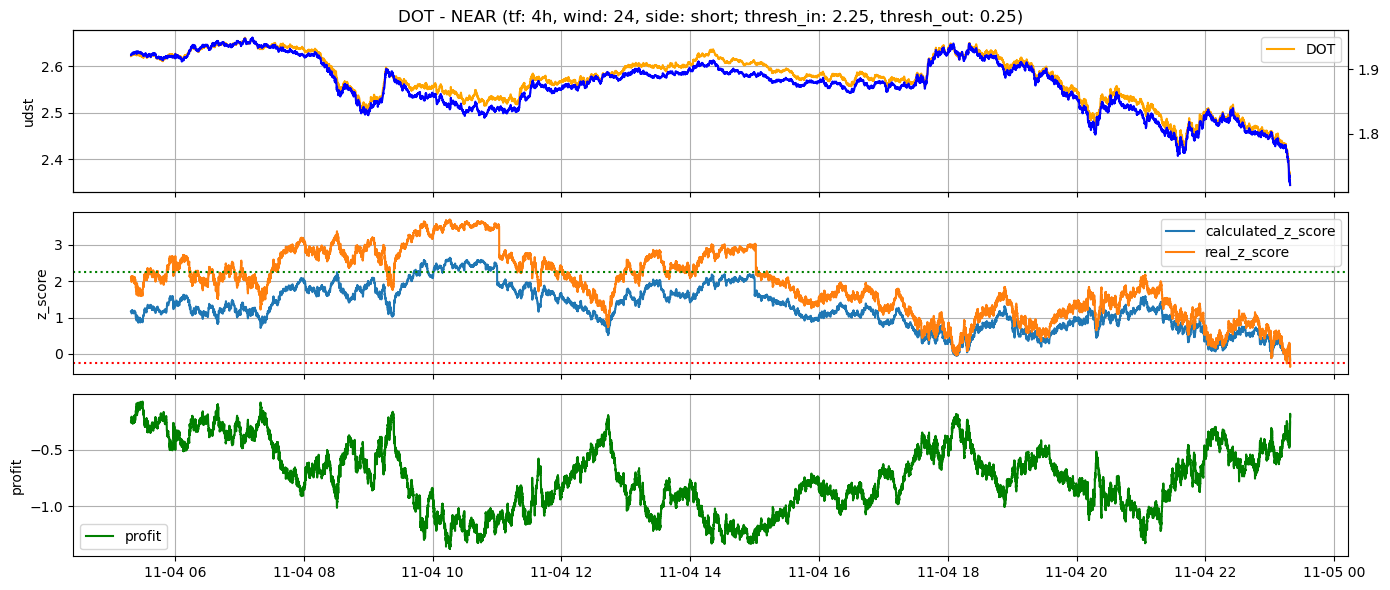

DOT - NEAR. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-04 05:18:50; Цены. DOT: 2.6211; NEAR: 1.922; z_score: 2.10; Std: DOT: 0.3033; NEAR: 0.5142
[CLOSE] Время: 2025-11-04 23:19:03; Цены. DOT: 2.3616; NEAR: 1.731; z_score: -0.31

[PROFIT]
usdt-neutral: 38.1 DOT(short): 9.78$, 51.9 NEAR(long): -10.02$; total profit: -0.23$
vol-neutral : 47.8 DOT(short): 12.27$, 38.5 NEAR(long): -7.43$; total profit: 4.84$
beta-neutral: 56.4 DOT(short): 14.48$, 27.0 NEAR(long): -5.21$; total profit: 9.27$
Ошибка с парой CRV - SUI



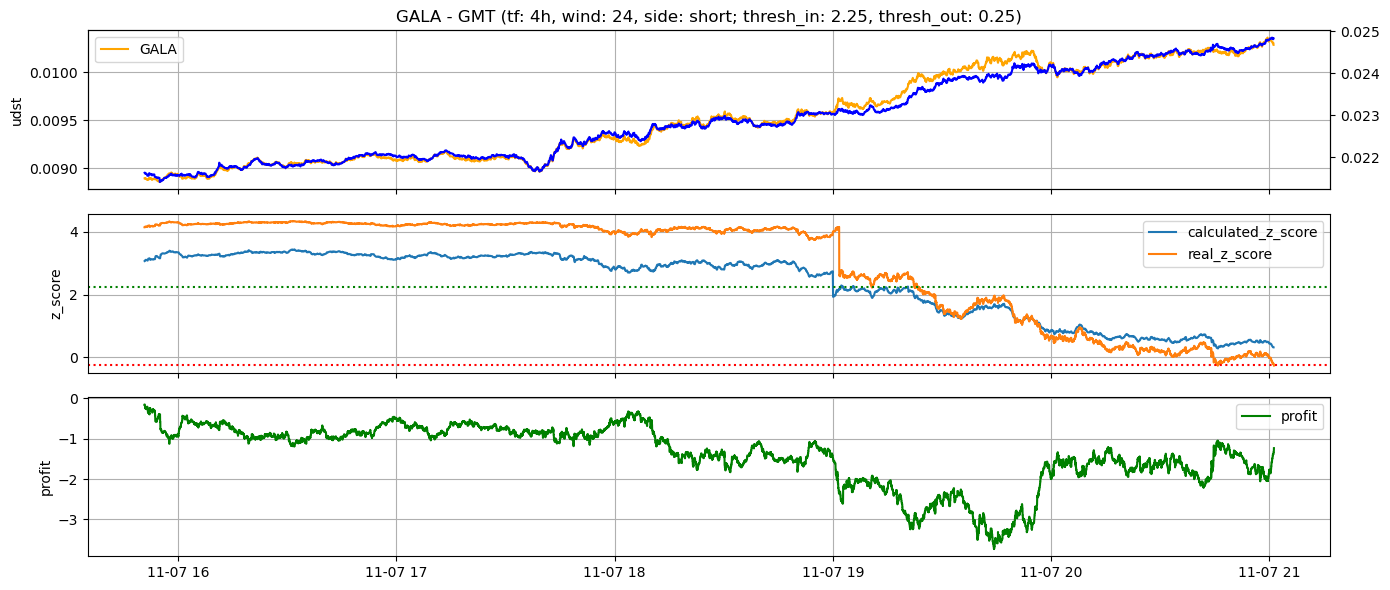

GALA - GMT. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-07 15:50:46; Цены. GALA: 0.008895; GMT: 0.02163; z_score: 4.14; Std: GALA: 0.0028; GMT: 0.0095
[CLOSE] Время: 2025-11-07 21:01:17; Цены. GALA: 0.010292; GMT: 0.02485; z_score: -0.26

[PROFIT]
usdt-neutral: 11229.0 GALA(short): -15.82$, 4615.0 GMT(long): 14.73$; total profit: -1.08$
vol-neutral : 17316.0 GALA(short): -24.37$, 2104.0 GMT(long): 6.72$; total profit: -17.65$
beta-neutral: 13546.0 GALA(short): -19.07$, 3670.0 GMT(long): 11.72$; total profit: -7.34$


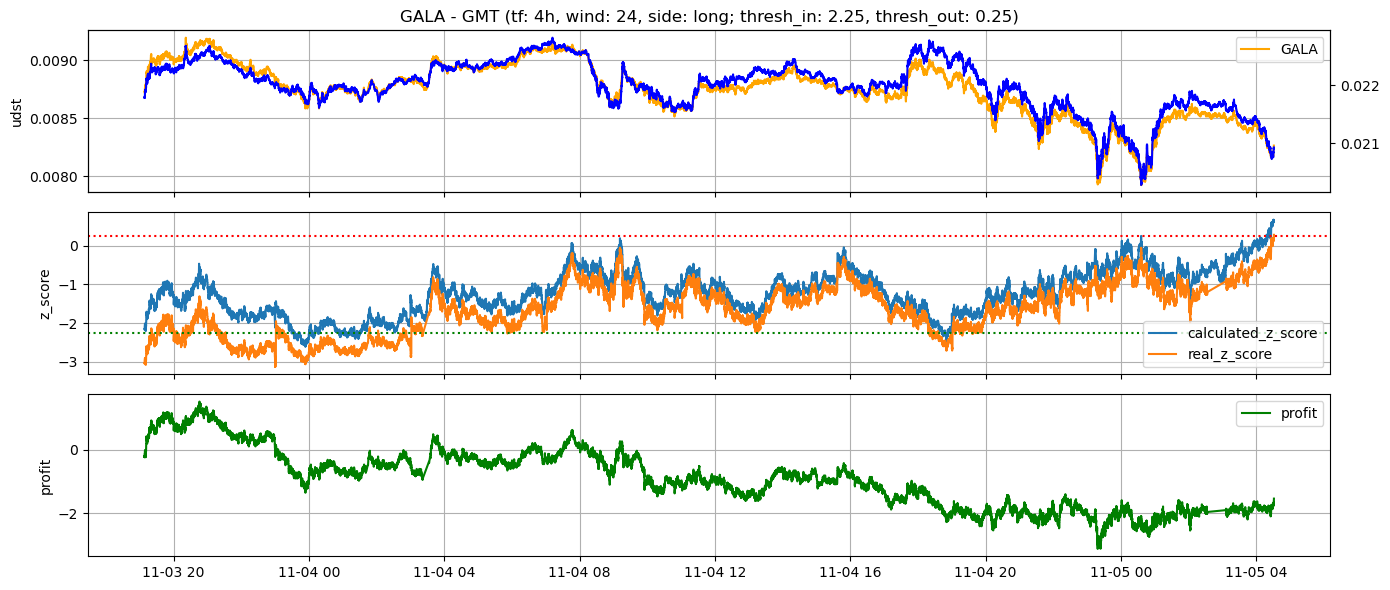

GALA - GMT. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-03 19:08:24; Цены. GALA: 0.00872; GMT: 0.02178; z_score: -3.03; Std: GALA: 0.0028; GMT: 0.0095
[CLOSE] Время: 2025-11-05 04:31:19; Цены. GALA: 0.00826; GMT: 0.02092; z_score: 0.28

[PROFIT]
usdt-neutral: 11442.0 GALA(long): -5.40$, 4584.0 GMT(short): 3.86$; total profit: -1.53$
vol-neutral : 17664.0 GALA(long): -8.29$, 2090.0 GMT(short): 1.75$; total profit: -6.54$
beta-neutral: 13670.0 GALA(long): -6.42$, 3704.0 GMT(short): 3.10$; total profit: -3.32$
Ошибка с парой CVX - SUSHI



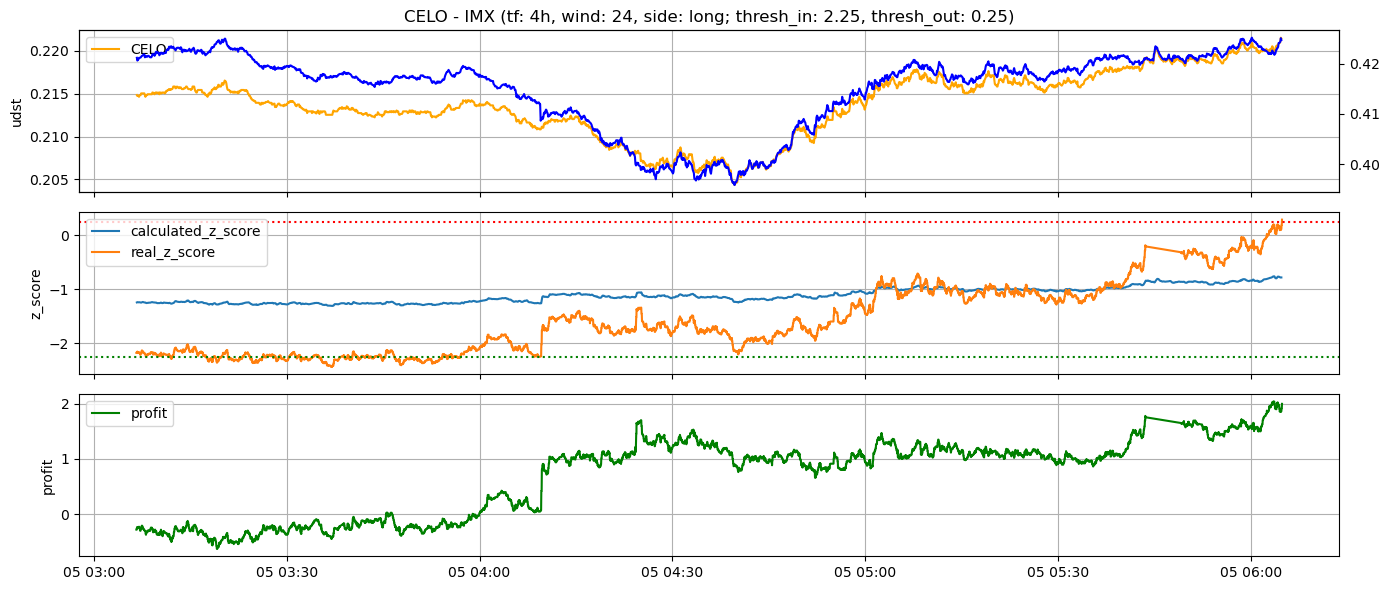

CELO - IMX. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-05 03:06:35; Цены. CELO: 0.215; IMX: 0.4213; z_score: -2.18; Std: CELO: 0.0464; IMX: 0.1019
[CLOSE] Время: 2025-11-05 06:04:52; Цены. CELO: 0.222; IMX: 0.4251; z_score: 0.29

[PROFIT]
usdt-neutral: 464.6 CELO(long): 3.14$, 237.1 IMX(short): -1.01$; total profit: 2.13$
vol-neutral : 637.7 CELO(long): 4.31$, 148.2 IMX(short): -0.63$; total profit: 3.68$
beta-neutral: 641.2 CELO(long): 4.33$, 147.2 IMX(short): -0.63$; total profit: 3.71$
Ошибка с парой CRV - SUI



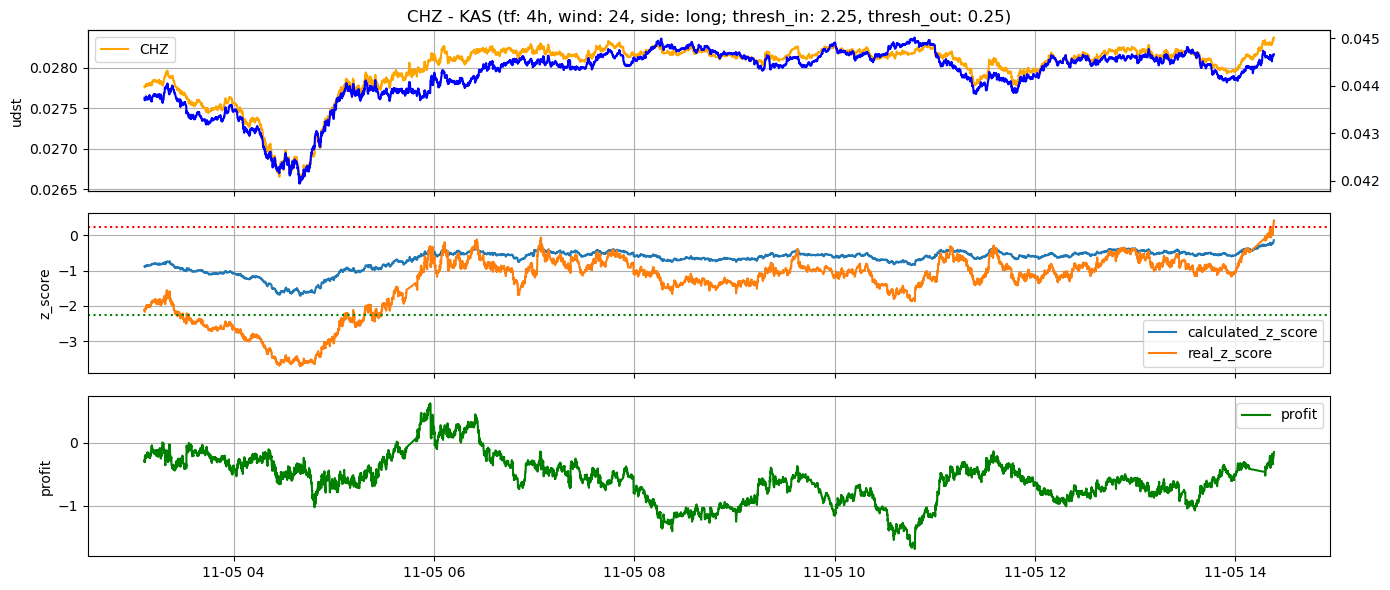

CHZ - KAS. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-05 03:06:36; Цены. CHZ: 0.02778; KAS: 0.04373; z_score: -2.11; Std: CHZ: 0.0165; KAS: 0.0043
[CLOSE] Время: 2025-11-05 14:23:05; Цены. CHZ: 0.02837; KAS: 0.04466; z_score: 0.42

[PROFIT]
usdt-neutral: 3595.0 CHZ(long): 2.00$, 2280.0 KAS(short): -2.22$; total profit: -0.22$
vol-neutral : 1474.0 CHZ(long): 0.82$, 3620.0 KAS(short): -3.54$; total profit: -2.72$
beta-neutral: 1126.0 CHZ(long): 0.63$, 3850.0 KAS(short): -3.77$; total profit: -3.14$
Ошибка с парой MORPHO - STX

Ошибка с парой CVX - SUSHI



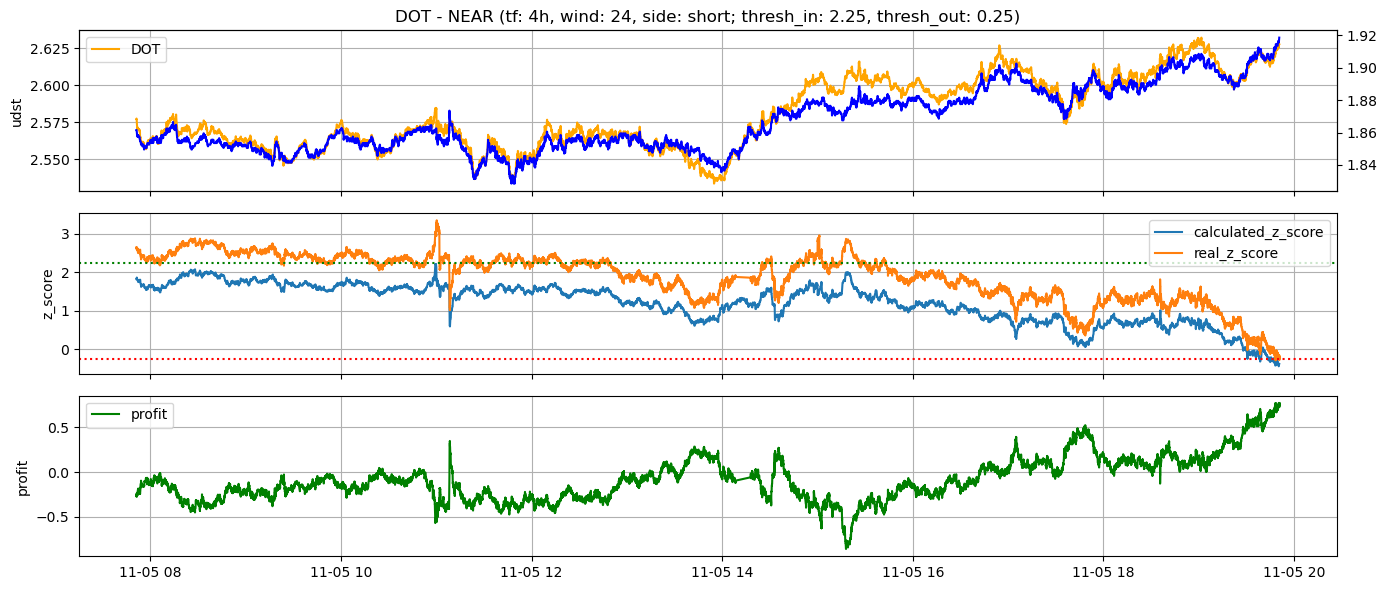

DOT - NEAR. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-05 07:51:05; Цены. DOT: 2.5765; NEAR: 1.862; z_score: 2.64; Std: DOT: 0.3033; NEAR: 0.5142
[CLOSE] Время: 2025-11-05 19:50:47; Цены. DOT: 2.628; NEAR: 1.919; z_score: -0.26

[PROFIT]
usdt-neutral: 38.7 DOT(short): -2.12$, 53.6 NEAR(long): 2.94$; total profit: 0.82$
vol-neutral : 48.7 DOT(short): -2.65$, 39.7 NEAR(long): 2.18$; total profit: -0.47$
beta-neutral: 57.6 DOT(short): -3.13$, 27.6 NEAR(long): 1.52$; total profit: -1.62$


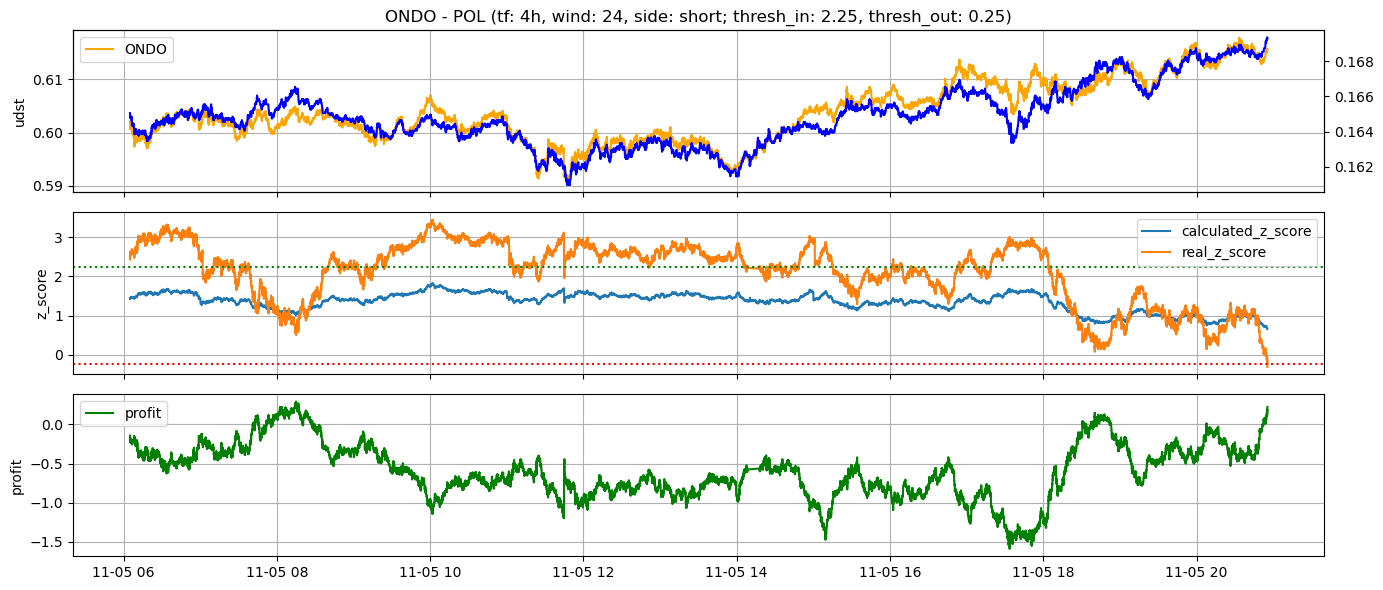

ONDO - POL. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-05 06:04:52; Цены. ONDO: 0.602; POL: 0.165; z_score: 2.53; Std: ONDO: 0.0297; POL: 0.1196
[CLOSE] Время: 2025-11-05 20:55:31; Цены. ONDO: 0.6153; POL: 0.1694; z_score: -0.32

[PROFIT]
usdt-neutral: 165.0 ONDO(short): -2.28$, 605.0 POL(long): 2.56$; total profit: 0.28$
vol-neutral : 264.0 ONDO(short): -3.69$, 239.0 POL(long): 1.01$; total profit: -2.68$
beta-neutral: 312.0 ONDO(short): -4.36$, 66.0 POL(long): 0.28$; total profit: -4.08$


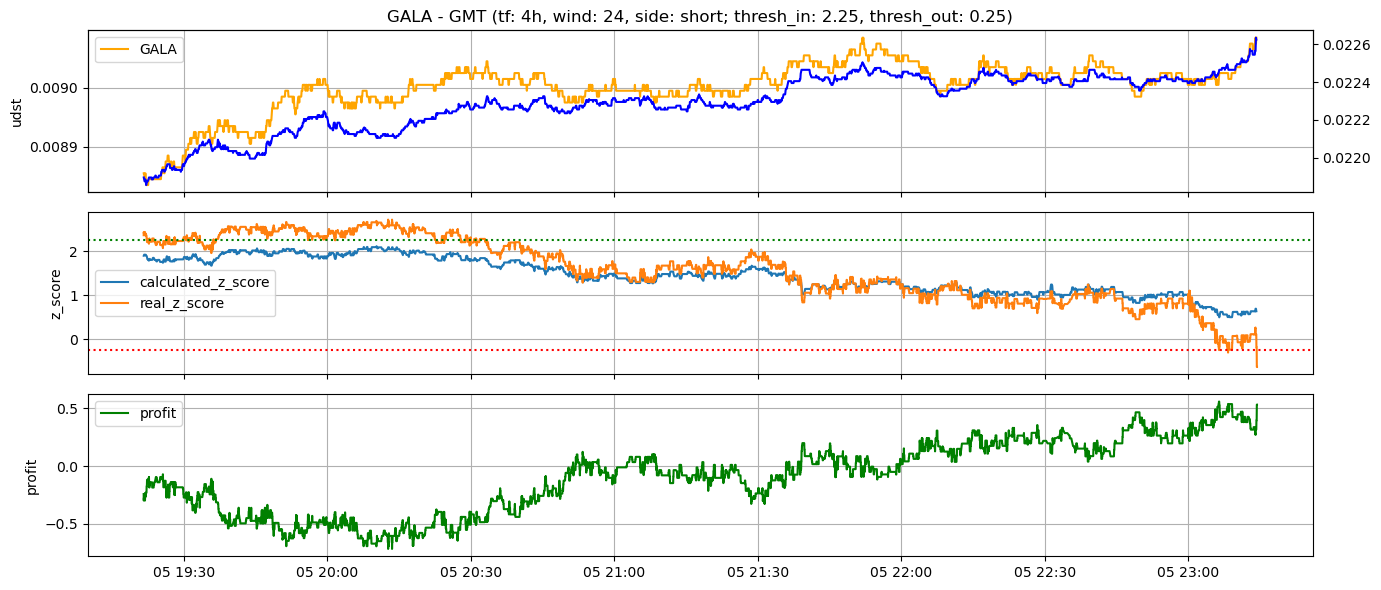

GALA - GMT. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-05 19:21:37; Цены. GALA: 0.00885; GMT: 0.02189; z_score: 2.36; Std: GALA: 0.0028; GMT: 0.0095
[CLOSE] Время: 2025-11-05 23:14:24; Цены. GALA: 0.00908; GMT: 0.0226; z_score: -0.64

[PROFIT]
usdt-neutral: 11287.0 GALA(short): -2.71$, 4561.0 GMT(long): 3.13$; total profit: 0.42$
vol-neutral : 17404.0 GALA(short): -4.17$, 2079.0 GMT(long): 1.43$; total profit: -2.75$
beta-neutral: 13523.0 GALA(short): -3.24$, 3664.0 GMT(long): 2.51$; total profit: -0.73$


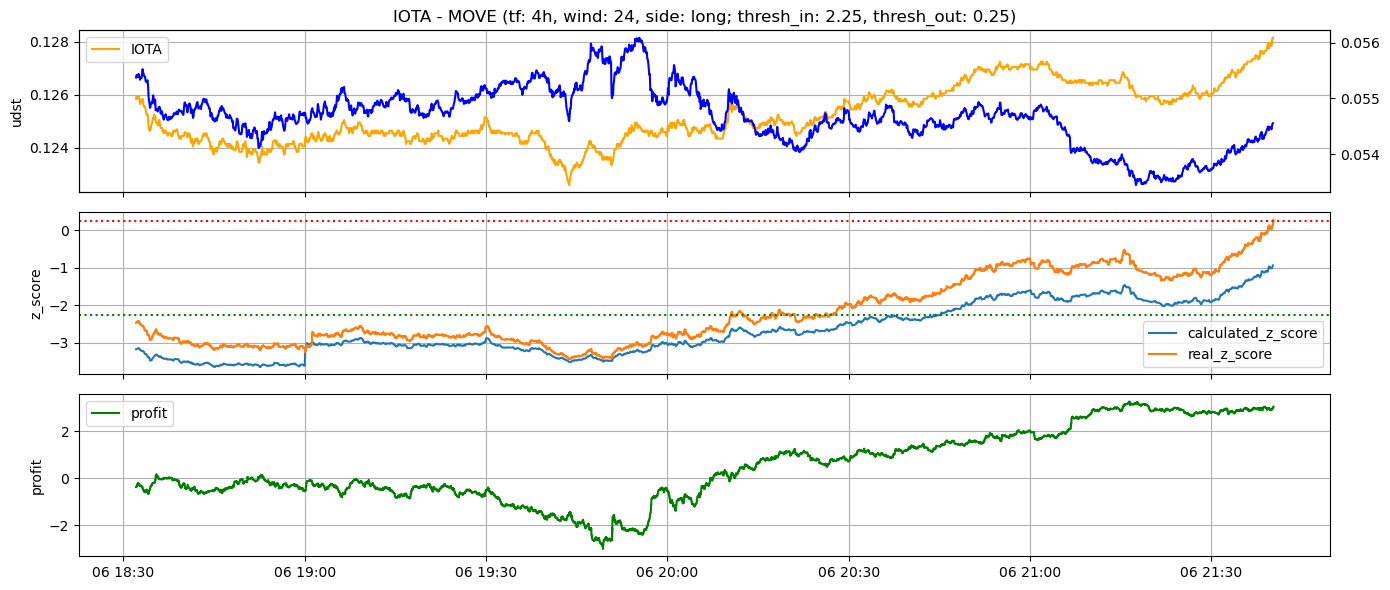

IOTA - MOVE. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-06 18:32:02; Цены. IOTA: 0.1259; MOVE: 0.05536; z_score: -2.47; Std: IOTA: 0.0272; MOVE: 0.0344
[CLOSE] Время: 2025-11-06 21:40:18; Цены. IOTA: 0.1281; MOVE: 0.05457; z_score: 0.29

[PROFIT]
usdt-neutral: 792.7 IOTA(long): 1.63$, 1804.0 MOVE(short): 1.32$; total profit: 2.96$
vol-neutral : 885.0 IOTA(long): 1.82$, 1591.0 MOVE(short): 1.16$; total profit: 2.98$
beta-neutral: 1274.0 IOTA(long): 2.62$, 713.0 MOVE(short): 0.52$; total profit: 3.14$


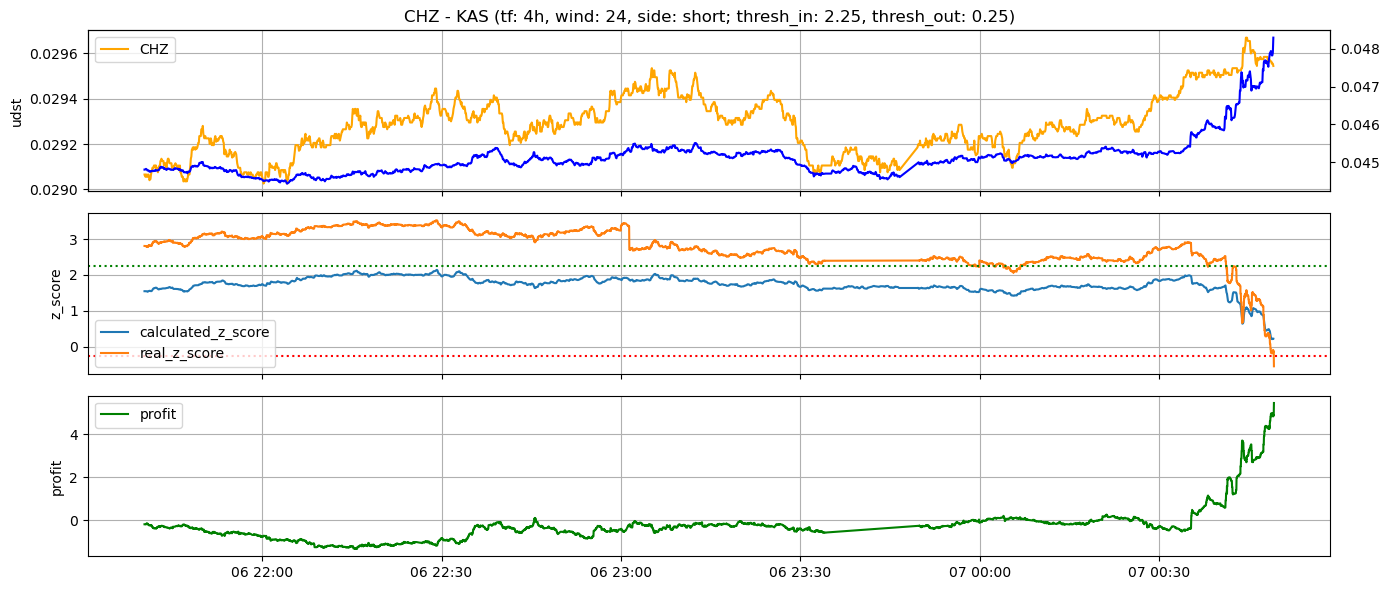

CHZ - KAS. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-06 21:40:18; Цены. CHZ: 0.02907; KAS: 0.0448; z_score: 2.81; Std: CHZ: 0.0165; KAS: 0.0043
[CLOSE] Время: 2025-11-07 00:49:13; Цены. CHZ: 0.02956; KAS: 0.0486; z_score: -0.55

[PROFIT]
usdt-neutral: 3437.0 CHZ(short): -1.79$, 2220.0 KAS(long): 8.32$; total profit: 6.52$
vol-neutral : 1402.0 CHZ(short): -0.73$, 3520.0 KAS(long): 13.20$; total profit: 12.46$
beta-neutral: 1090.0 CHZ(short): -0.57$, 3730.0 KAS(long): 13.98$; total profit: 13.41$


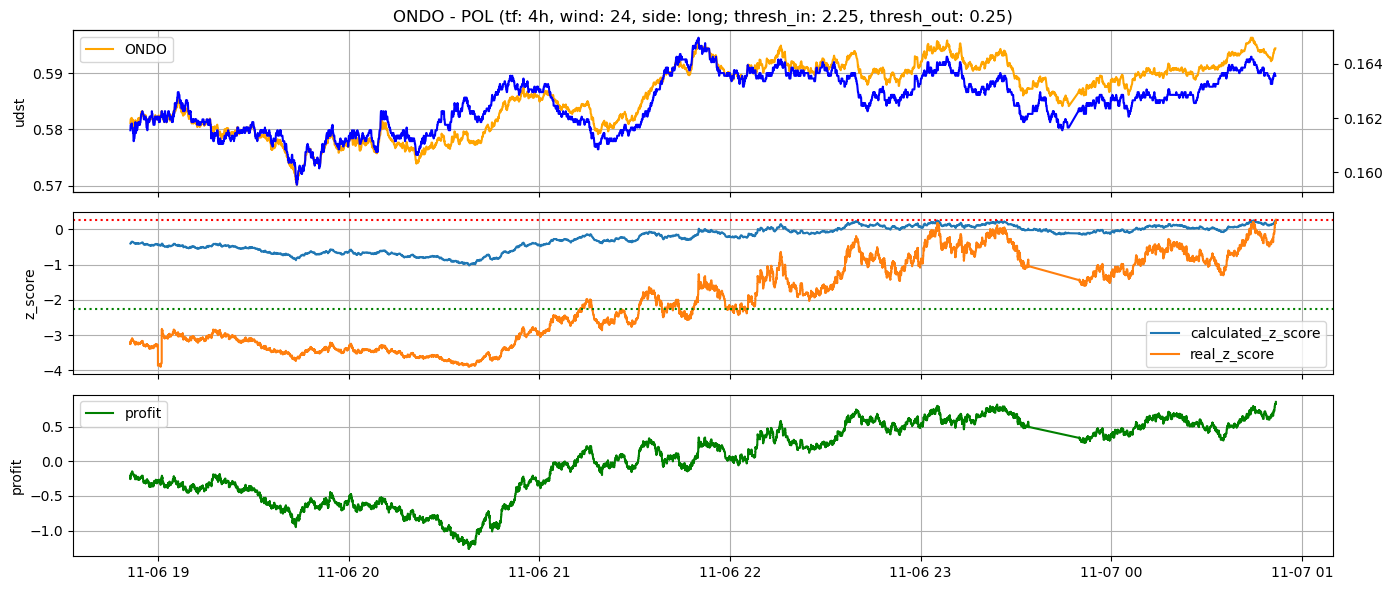

ONDO - POL. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-06 18:51:16; Цены. ONDO: 0.5811; POL: 0.1616; z_score: -3.24; Std: ONDO: 0.0297; POL: 0.1196
[CLOSE] Время: 2025-11-07 00:51:46; Цены. ONDO: 0.5951; POL: 0.1636; z_score: 0.27

[PROFIT]
usdt-neutral: 171.0 ONDO(long): 2.28$, 618.0 POL(short): -1.34$; total profit: 0.94$
vol-neutral : 273.0 ONDO(long): 3.65$, 244.0 POL(short): -0.53$; total profit: 3.11$
beta-neutral: 323.0 ONDO(long): 4.31$, 68.0 POL(short): -0.15$; total profit: 4.16$
Ошибка с парой MORPHO - STX



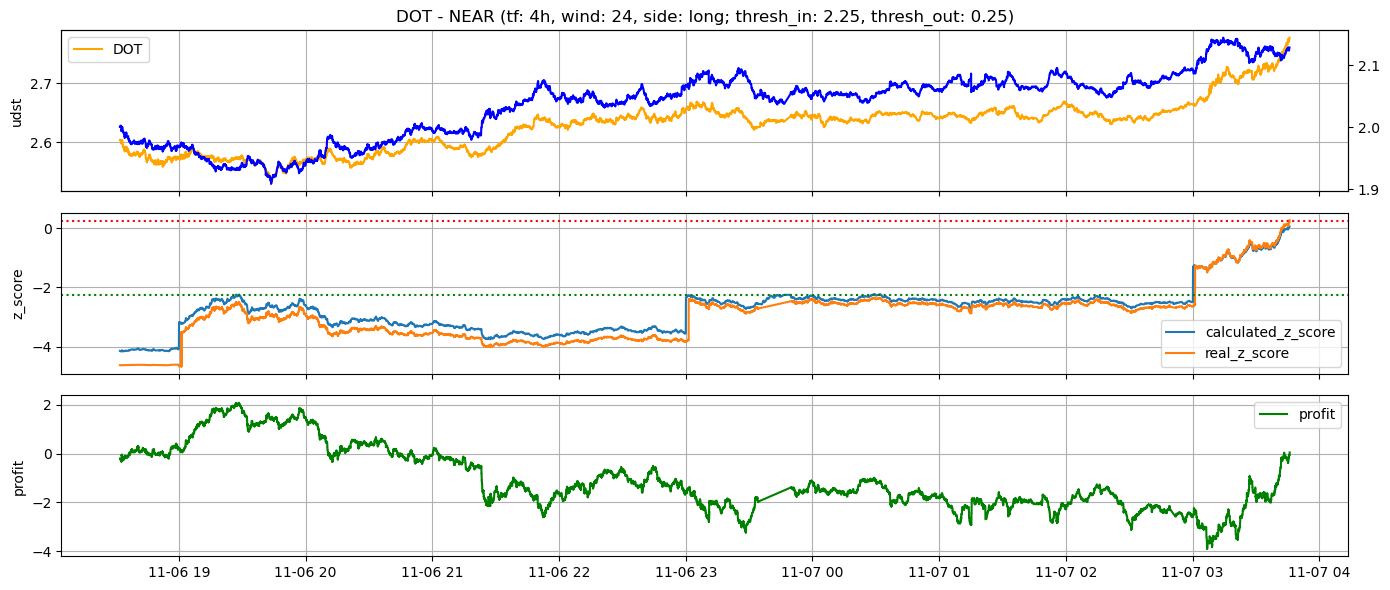

DOT - NEAR. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-06 18:32:04; Цены. DOT: 2.6035; NEAR: 2.0; z_score: -4.61; Std: DOT: 0.3033; NEAR: 0.5142
[CLOSE] Время: 2025-11-07 03:45:57; Цены. DOT: 2.777; NEAR: 2.127; z_score: 0.26

[PROFIT]
usdt-neutral: 38.3 DOT(long): 6.62$, 49.9 NEAR(short): -6.46$; total profit: 0.16$
vol-neutral : 48.2 DOT(long): 8.22$, 37.0 NEAR(short): -4.78$; total profit: 3.44$
beta-neutral: 56.1 DOT(long): 9.57$, 26.8 NEAR(short): -3.46$; total profit: 6.10$


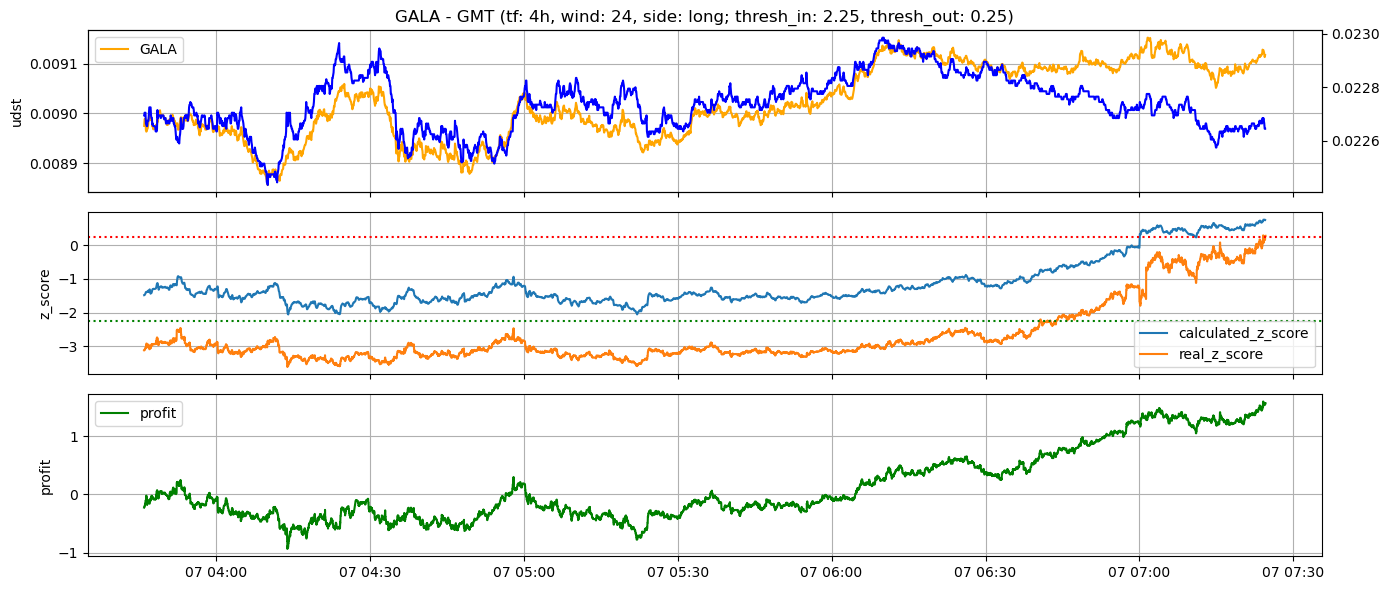

GALA - GMT. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-07 03:45:57; Цены. GALA: 0.008972; GMT: 0.02269; z_score: -3.12; Std: GALA: 0.0028; GMT: 0.0095
[CLOSE] Время: 2025-11-07 07:24:35; Цены. GALA: 0.009114; GMT: 0.02264; z_score: 0.28

[PROFIT]
usdt-neutral: 11131.0 GALA(long): 1.47$, 4402.0 GMT(short): 0.11$; total profit: 1.58$
vol-neutral : 17168.0 GALA(long): 2.27$, 2006.0 GMT(short): 0.05$; total profit: 2.32$
beta-neutral: 13220.0 GALA(long): 1.75$, 3582.0 GMT(short): 0.09$; total profit: 1.84$


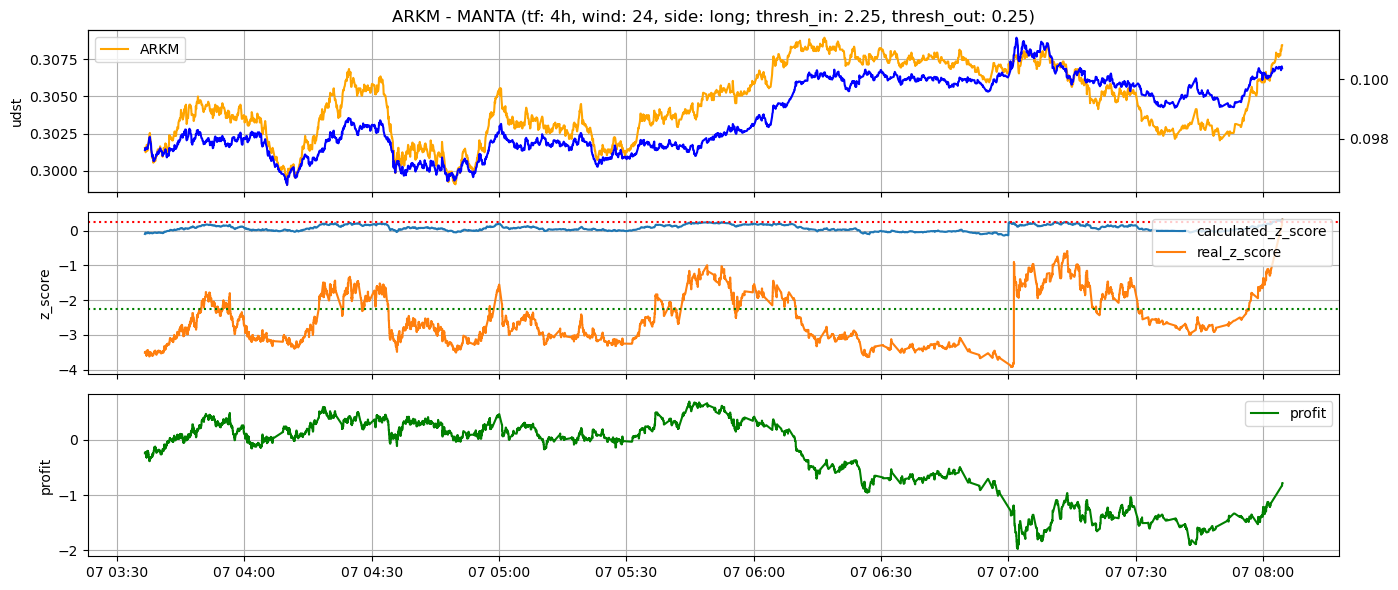

ARKM - MANTA. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-07 03:36:33; Цены. ARKM: 0.3015; MANTA: 0.09762; z_score: -3.51; Std: ARKM: 0.0979; MANTA: 0.0506
[CLOSE] Время: 2025-11-07 08:04:35; Цены. ARKM: 0.3085; MANTA: 0.1004; z_score: 0.31

[PROFIT]
usdt-neutral: 331.0 ARKM(long): 2.21$, 1023.4 MANTA(short): -2.95$; total profit: -0.75$
vol-neutral : 225.0 ARKM(long): 1.50$, 1347.4 MANTA(short): -3.89$; total profit: -2.39$
beta-neutral: 421.0 ARKM(long): 2.81$, 745.5 MANTA(short): -2.15$; total profit: 0.65$


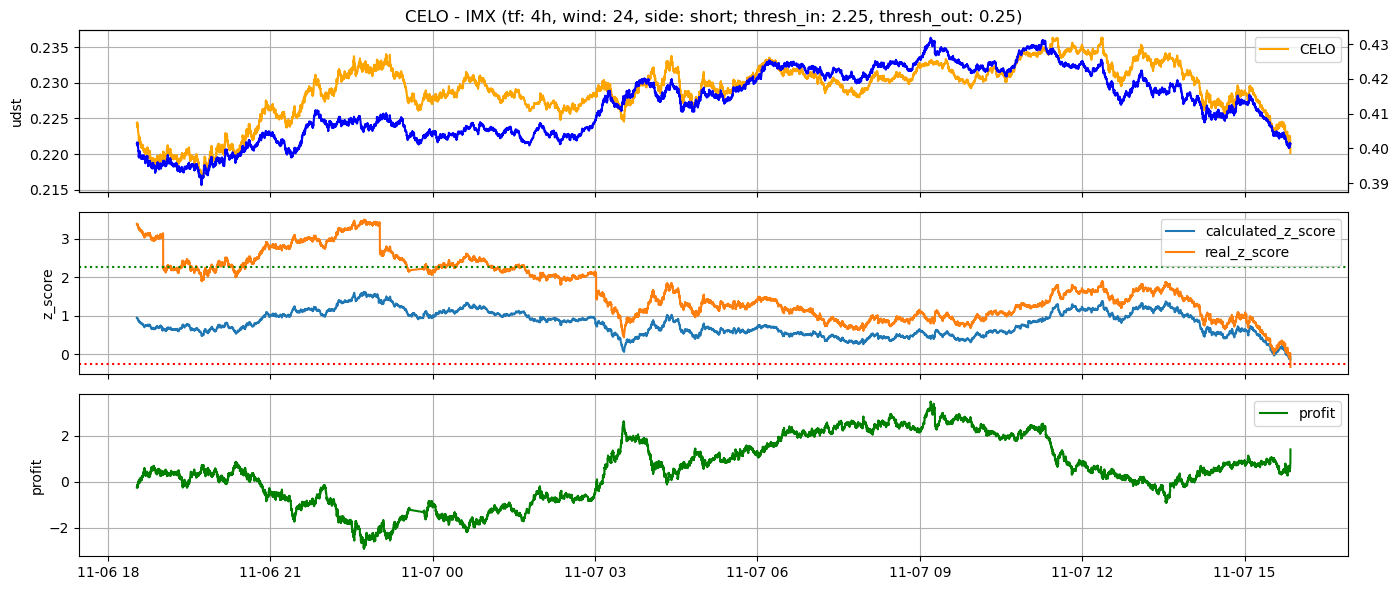

CELO - IMX. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-06 18:32:02; Цены. CELO: 0.2244; IMX: 0.4016; z_score: 3.38; Std: CELO: 0.0464; IMX: 0.1019
[CLOSE] Время: 2025-11-07 15:50:46; Цены. CELO: 0.2205; IMX: 0.4015; z_score: -0.33

[PROFIT]
usdt-neutral: 445.5 CELO(short): 1.64$, 248.7 IMX(long): -0.17$; total profit: 1.47$
vol-neutral : 611.0 CELO(short): 2.23$, 155.4 IMX(long): -0.08$; total profit: 2.15$
beta-neutral: 631.3 CELO(short): 2.31$, 144.9 IMX(long): -0.08$; total profit: 2.23$
Ошибка с парой CVX - SUSHI



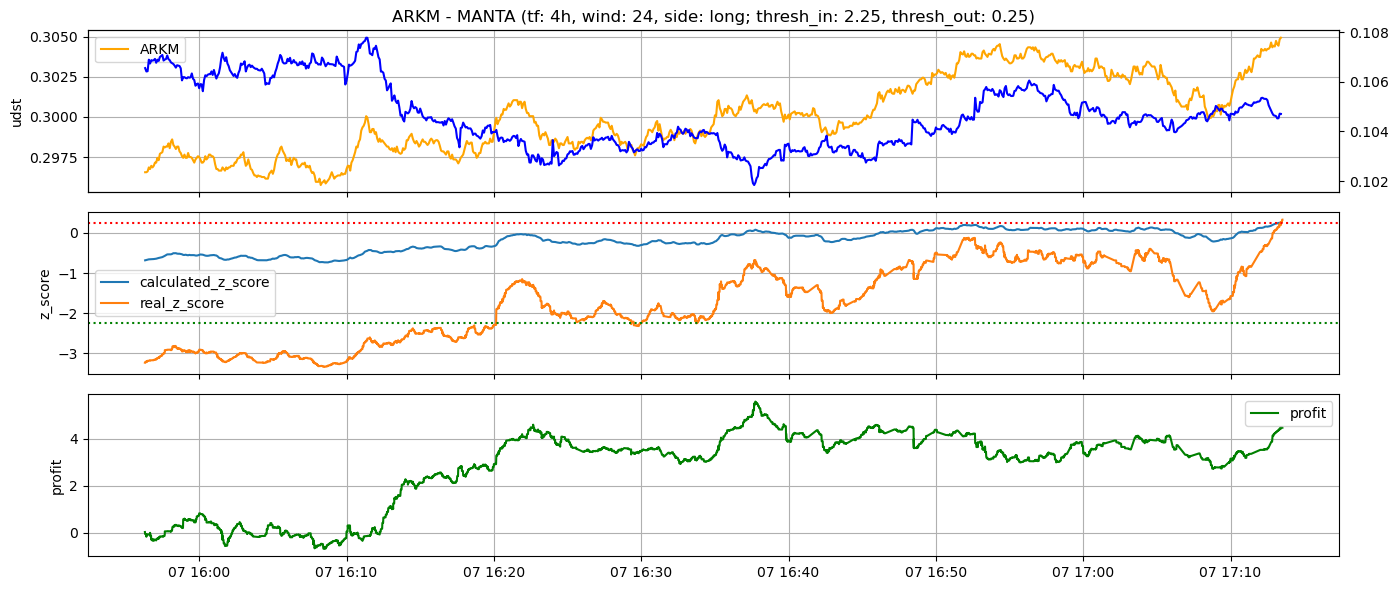

ARKM - MANTA. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-07 15:56:16; Цены. ARKM: 0.2964; MANTA: 0.10658; z_score: -3.24; Std: ARKM: 0.0979; MANTA: 0.0506
[CLOSE] Время: 2025-11-07 17:13:33; Цены. ARKM: 0.3051; MANTA: 0.10487; z_score: 0.33

[PROFIT]
usdt-neutral: 336.0 ARKM(long): 2.81$, 937.9 MANTA(short): 1.49$; total profit: 4.31$
vol-neutral : 229.0 ARKM(long): 1.92$, 1234.1 MANTA(short): 1.97$; total profit: 3.88$
beta-neutral: 412.0 ARKM(long): 3.45$, 729.6 MANTA(short): 1.16$; total profit: 4.61$
Ошибка с парой LDO - SAND



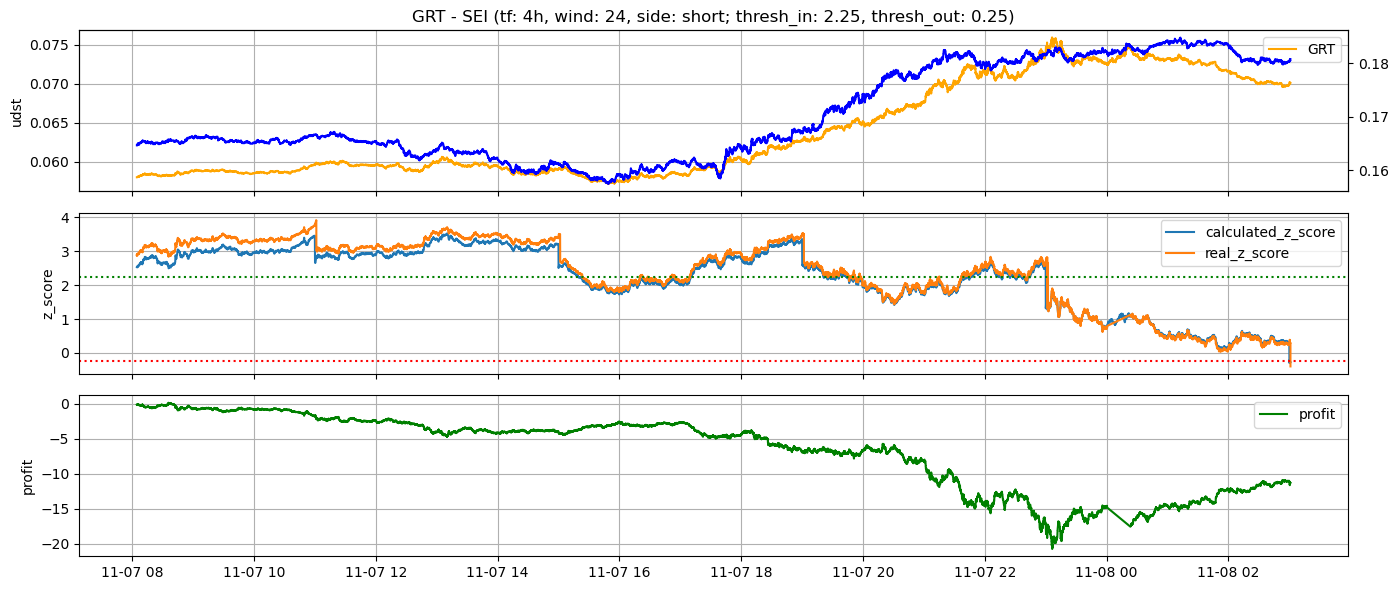

GRT - SEI. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-07 08:04:35; Цены. GRT: 0.05798; SEI: 0.1646; z_score: 2.88; Std: GRT: 0.0148; SEI: 0.0570
[CLOSE] Время: 2025-11-08 03:01:08; Цены. GRT: 0.07022; SEI: 0.1809; z_score: -0.40

[PROFIT]
usdt-neutral: 1723.1 GRT(short): -21.20$, 606.0 SEI(long): 9.75$; total profit: -11.45$
vol-neutral : 2732.5 GRT(short): -33.64$, 249.0 SEI(long): 4.01$; total profit: -29.63$
beta-neutral: 2476.8 GRT(short): -30.49$, 341.0 SEI(long): 5.49$; total profit: -25.00$
Ошибка с парой CRV - SUI



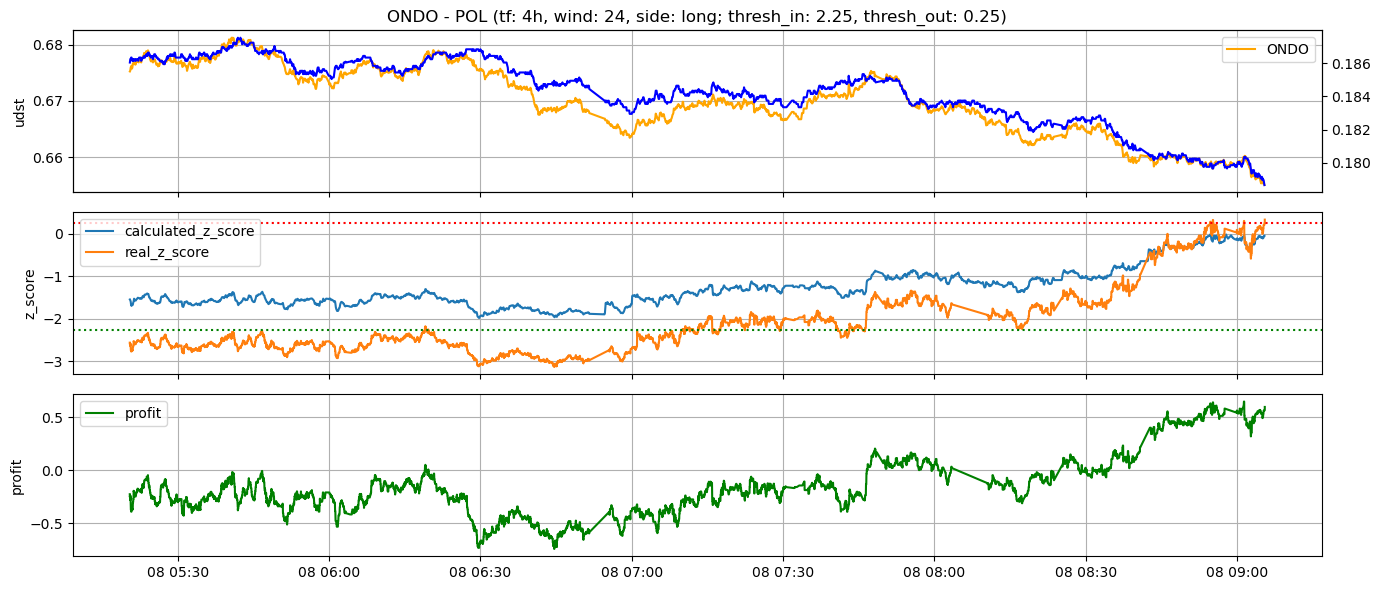

ONDO - POL. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-08 05:20:28; Цены. ONDO: 0.6752; POL: 0.1858; z_score: -2.56; Std: ONDO: 0.0297; POL: 0.1196
[CLOSE] Время: 2025-11-08 09:05:31; Цены. ONDO: 0.6547; POL: 0.1786; z_score: 0.33

[PROFIT]
usdt-neutral: 147.0 ONDO(long): -3.11$, 537.0 POL(short): 3.76$; total profit: 0.65$
vol-neutral : 235.0 ONDO(long): -4.99$, 212.0 POL(short): 1.48$; total profit: -3.51$
beta-neutral: 278.0 ONDO(long): -5.90$, 59.0 POL(short): 0.41$; total profit: -5.49$


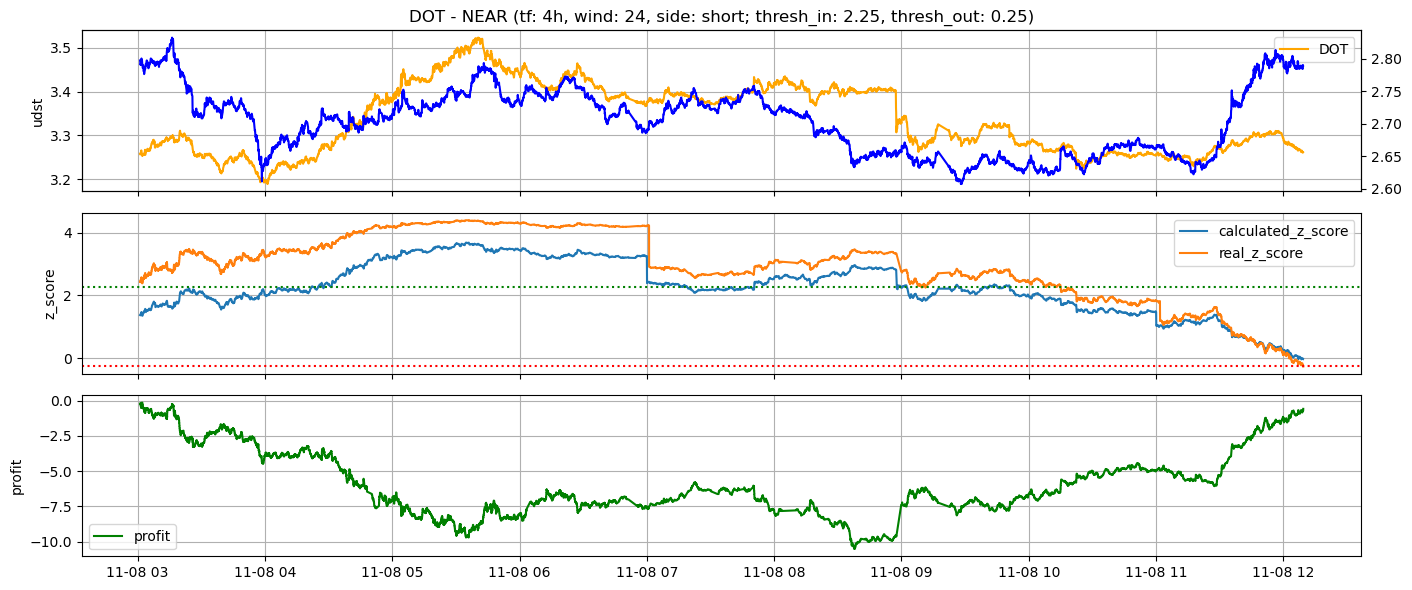

DOT - NEAR. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-08 03:01:08; Цены. DOT: 3.2581; NEAR: 2.797; z_score: 2.43; Std: DOT: 0.3033; NEAR: 0.5142
[CLOSE] Время: 2025-11-08 12:09:21; Цены. DOT: 3.2621; NEAR: 2.79; z_score: -0.27

[PROFIT]
usdt-neutral: 30.6 DOT(short): -0.23$, 35.7 NEAR(long): -0.37$; total profit: -0.60$
vol-neutral : 38.5 DOT(short): -0.29$, 26.4 NEAR(long): -0.27$; total profit: -0.56$
beta-neutral: 43.4 DOT(short): -0.33$, 20.7 NEAR(long): -0.21$; total profit: -0.54$


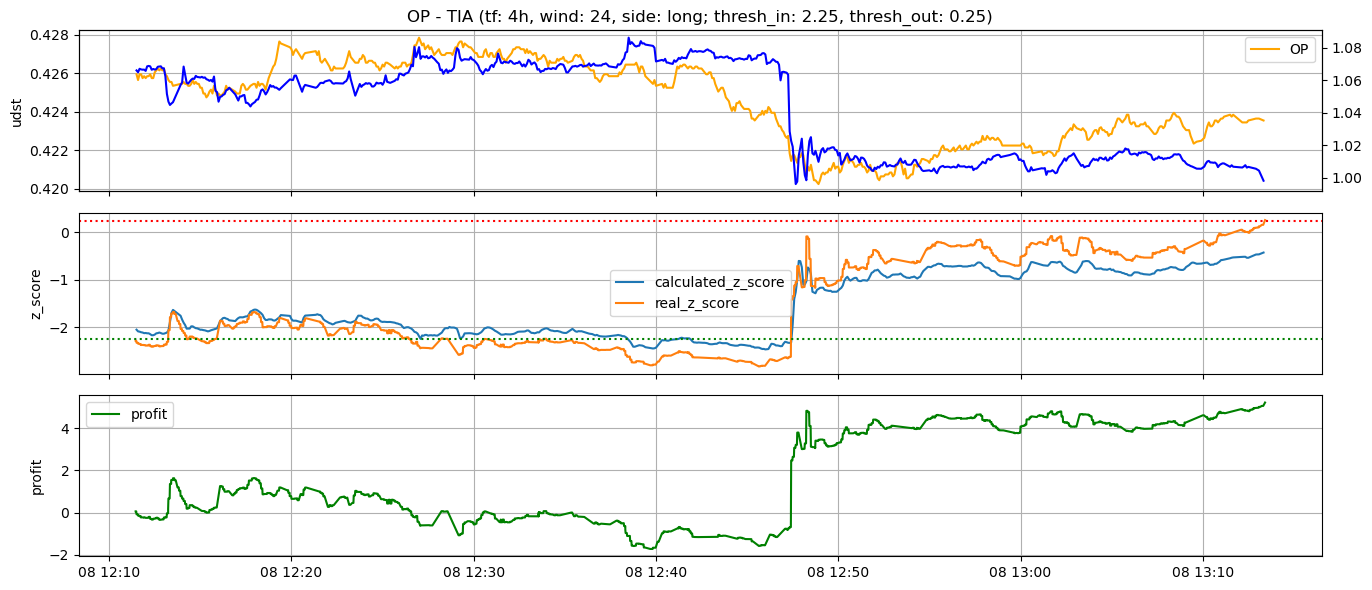

OP - TIA. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-08 12:11:25; Цены. OP: 0.4259; TIA: 1.0663; z_score: -2.28; Std: OP: 0.1244; TIA: 0.4578
[CLOSE] Время: 2025-11-08 13:13:26; Цены. OP: 0.4235; TIA: 1.001; z_score: 0.26

[PROFIT]
usdt-neutral: 234.2 OP(long): -0.67$, 93.7 TIA(short): 6.01$; total profit: 5.34$
vol-neutral : 368.4 OP(long): -1.06$, 39.9 TIA(short): 2.56$; total profit: 1.50$
beta-neutral: 313.5 OP(long): -0.90$, 62.2 TIA(short): 3.99$; total profit: 3.09$
Ошибка с парой LDO - SAND



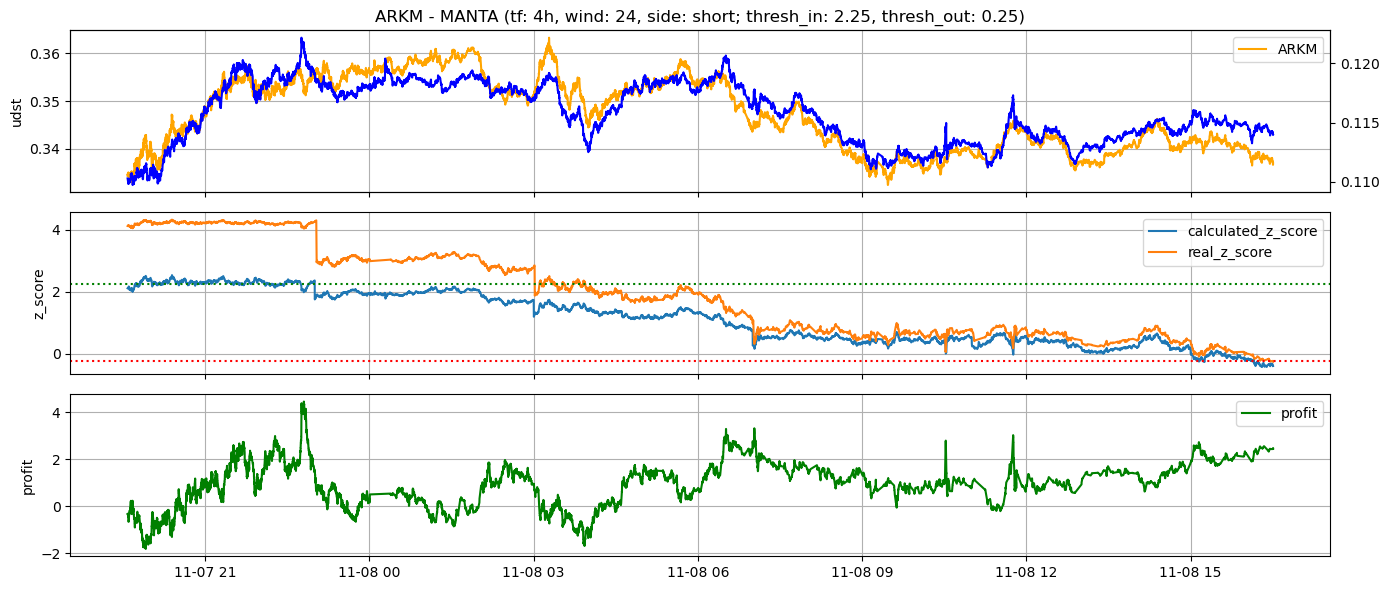

ARKM - MANTA. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-07 19:34:53; Цены. ARKM: 0.3342; MANTA: 0.11022; z_score: 4.12; Std: ARKM: 0.0979; MANTA: 0.0506
[CLOSE] Время: 2025-11-08 16:30:25; Цены. ARKM: 0.3367; MANTA: 0.11398; z_score: -0.25

[PROFIT]
usdt-neutral: 298.0 ARKM(short): -0.83$, 906.1 MANTA(long): 3.27$; total profit: 2.43$
vol-neutral : 202.0 ARKM(short): -0.58$, 1187.4 MANTA(long): 4.32$; total profit: 3.74$
beta-neutral: 375.0 ARKM(short): -1.08$, 664.0 MANTA(long): 2.41$; total profit: 1.34$


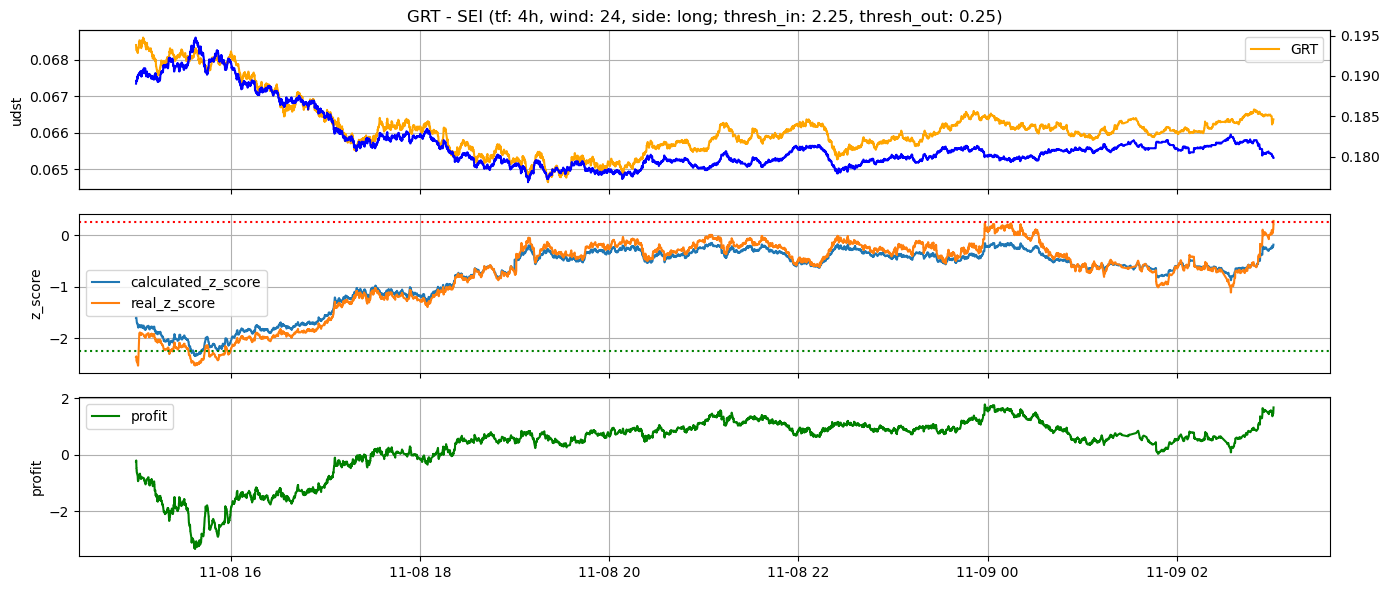

GRT - SEI. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-08 15:00:01; Цены. GRT: 0.06838; SEI: 0.189; z_score: -2.36; Std: GRT: 0.0148; SEI: 0.0570
[CLOSE] Время: 2025-11-09 03:01:12; Цены. GRT: 0.06638; SEI: 0.1797; z_score: 0.28

[PROFIT]
usdt-neutral: 1457.3 GRT(long): -3.03$, 528.0 SEI(short): 4.72$; total profit: 1.69$
vol-neutral : 2305.3 GRT(long): -4.78$, 216.0 SEI(short): 1.96$; total profit: -2.82$
beta-neutral: 2105.2 GRT(long): -4.37$, 290.0 SEI(short): 2.64$; total profit: -1.73$


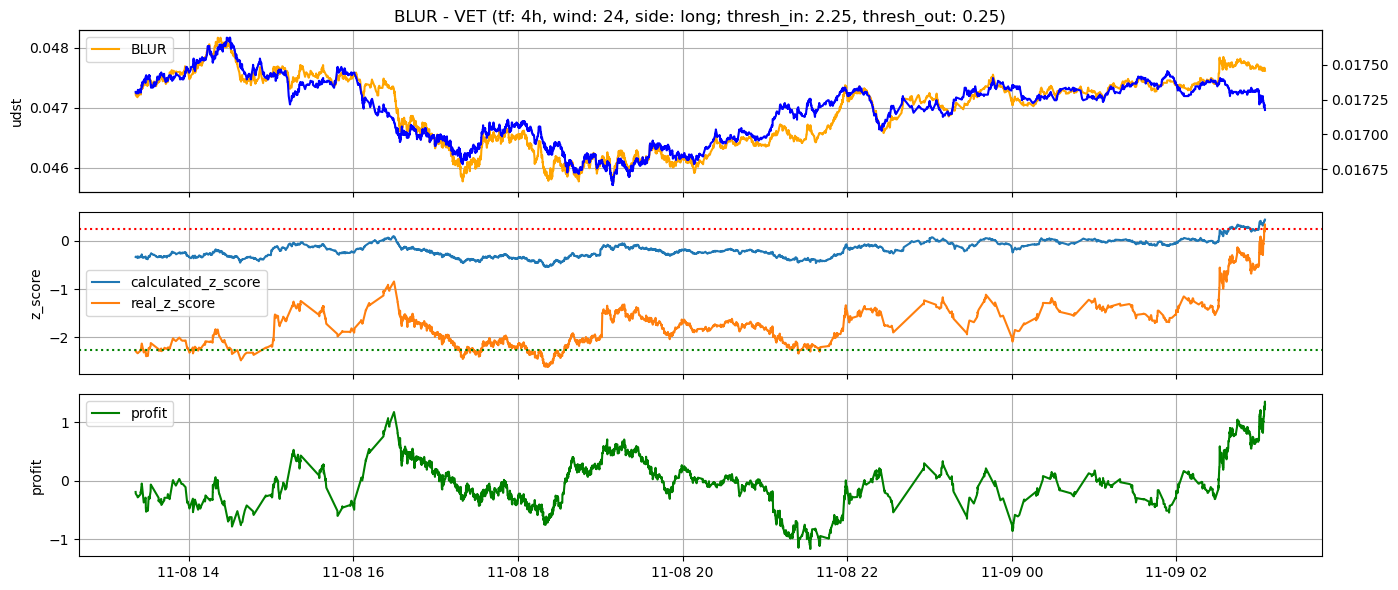

BLUR - VET. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-08 13:21:17; Цены. BLUR: 0.04721; VET: 0.0173; z_score: -2.27; Std: BLUR: 0.0035; VET: 0.0168
[CLOSE] Время: 2025-11-09 03:04:35; Цены. BLUR: 0.04762; VET: 0.01719; z_score: 0.27

[PROFIT]
usdt-neutral: 2111.0 BLUR(long): 0.74$, 5773.0 VET(short): 0.55$; total profit: 1.28$
vol-neutral : 3505.0 BLUR(long): 1.25$, 1970.0 VET(short): 0.18$; total profit: 1.43$
beta-neutral: 3947.0 BLUR(long): 1.41$, 782.0 VET(short): 0.07$; total profit: 1.48$


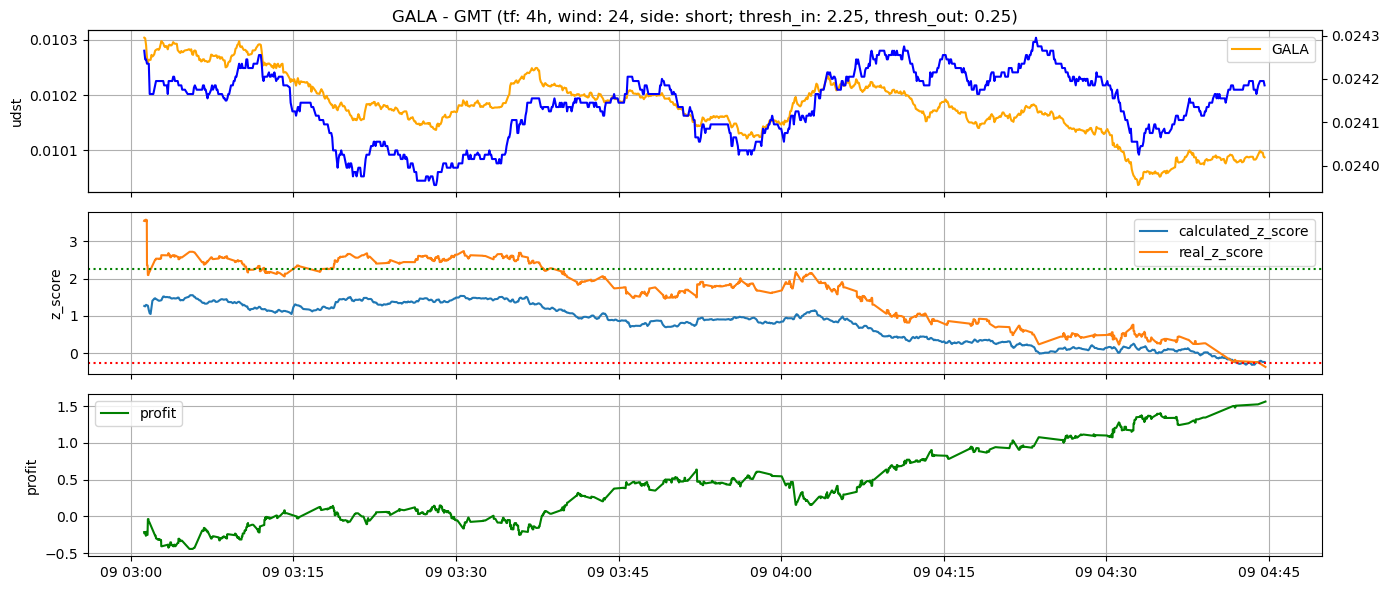

GALA - GMT. Side: short; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-09 03:01:12; Цены. GALA: 0.010304; GMT: 0.02427; z_score: 3.55; Std: GALA: 0.0028; GMT: 0.0095
[CLOSE] Время: 2025-11-09 04:44:42; Цены. GALA: 0.010088; GMT: 0.0242; z_score: -0.37

[PROFIT]
usdt-neutral: 9682.0 GALA(short): 1.98$, 4115.0 GMT(long): -0.40$; total profit: 1.58$
vol-neutral : 14948.0 GALA(short): 3.06$, 1875.0 GMT(long): -0.18$; total profit: 2.88$
beta-neutral: 11841.0 GALA(short): 2.42$, 3208.0 GMT(long): -0.31$; total profit: 2.11$


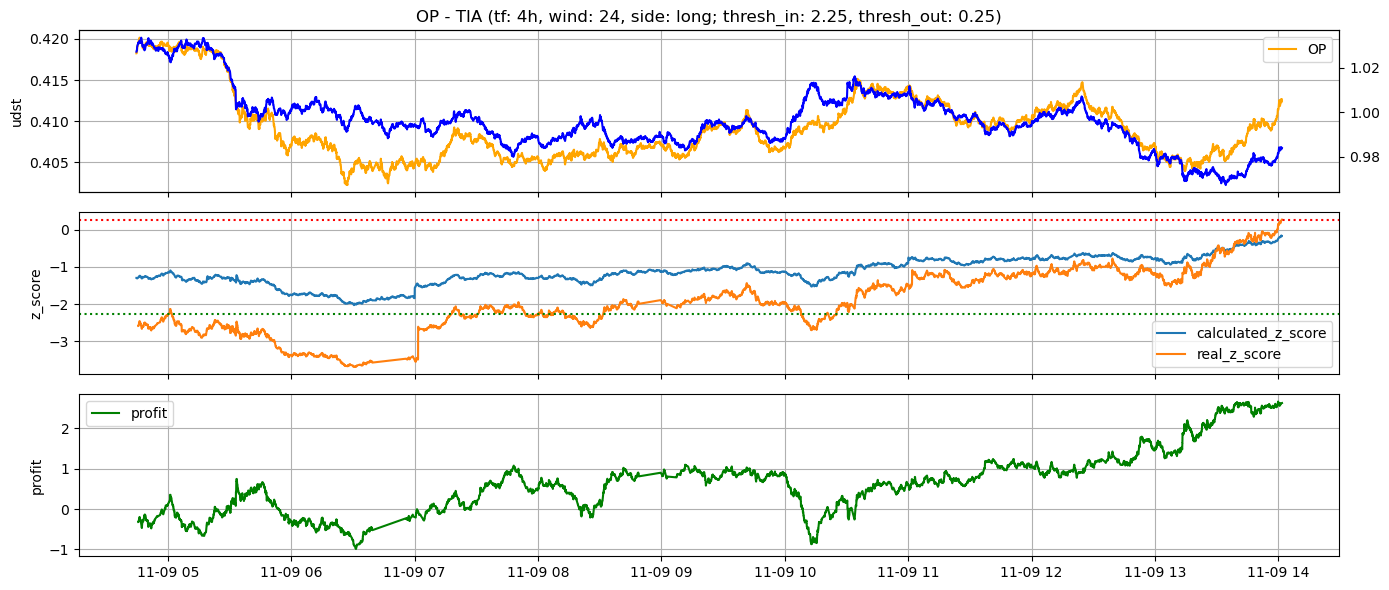

OP - TIA. Side: long; Timeframe: 4h; window: 24; thresh_in: 2.25, thresh_out: 0.25
[ OPEN] Время: 2025-11-09 04:44:42; Цены. OP: 0.4182; TIA: 1.0271; z_score: -2.58; Std: OP: 0.1244; TIA: 0.4578
[CLOSE] Время: 2025-11-09 14:01:46; Цены. OP: 0.4126; TIA: 0.9842; z_score: 0.27

[PROFIT]
usdt-neutral: 238.4 OP(long): -1.44$, 97.2 TIA(short): 4.07$; total profit: 2.63$
vol-neutral : 375.2 OP(long): -2.27$, 41.5 TIA(short): 1.73$; total profit: -0.54$
beta-neutral: 321.3 OP(long): -1.95$, 63.7 TIA(short): 2.66$; total profit: 0.72$


In [123]:
profit_arr, profit_vn_arr, profit_bn_arr  = [], [], []

for trade in trading_history.iter_rows(named=True):
    try:
        token_1 = trade['token_1']
        token_2 = trade['token_2']
    
        open_time = trade['open_time']
        close_time = trade['close_time']
    
        profit, profit_vn, profit_bn = create_report(token_1, token_2, tf, wind, thresh_in, thresh_out, 
                open_time, close_time, spread_method='lr',
                sl_ratio=0.5, fee_rate=0.00055, coin_information=coin_information,
                min_order=40)
        
        profit_arr.append(profit)
        profit_vn_arr.append(profit_vn)
        profit_bn_arr.append(profit_bn)
    except IndexError:
        print(f'Ошибка с парой {token_1} - {token_2}')
        print()

In [122]:
trading_history

shape: (51, 18)
┌─────────┬─────────┬─────────┬─────────┬───┬─────────┬─────────┬─────────┬─────────┐
│ token_1 ┆ token_2 ┆ open_ti ┆ close_t ┆ … ┆ leverag ┆ pnl_1   ┆ pnl_2   ┆ profit  │
│ ---     ┆ ---     ┆ me      ┆ ime     ┆   ┆ e       ┆ ---     ┆ ---     ┆ ---     │
│ str     ┆ str     ┆ ---     ┆ ---     ┆   ┆ ---     ┆ f64     ┆ f64     ┆ f64     │
│         ┆         ┆ datetim ┆ datetim ┆   ┆ f64     ┆         ┆         ┆         │
│         ┆         ┆ e[μs,   ┆ e[μs,   ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ Europe/ ┆ Europe/ ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ Moscow] ┆ Moscow] ┆   ┆         ┆         ┆         ┆         │
╞═════════╪═════════╪═════════╪═════════╪═══╪═════════╪═════════╪═════════╪═════════╡
│ CELO    ┆ IMX     ┆ 2025-11 ┆ 2025-11 ┆ … ┆ 2.0     ┆ 7.34779 ┆ -15.019 ┆ -7.6713 │
│         ┆         ┆ -02 00: ┆ -04 01: ┆   ┆         ┆ 4       ┆ 162     ┆ 68      │
│         ┆         ┆ 44:29   ┆ 07:47   ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ MSK     ┆ MSK     ┆   ┆         ┆         ┆         ┆         │
│ GALA    ┆ GMT     ┆ 2025-11 ┆ 2025-11 ┆ … ┆ 2.0     ┆ -0.8748 ┆ 1.44419 ┆ 0.56929 │
│         ┆         ┆ -02 00: ┆ -02 07: ┆   ┆         ┆ 98      ┆ 6       ┆ 8       │
│         ┆         ┆ 44:30   ┆ 14:17   ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ MSK     ┆ MSK     ┆   ┆         ┆         ┆         ┆         │
│ OP      ┆ TIA     ┆ 2025-11 ┆ 2025-11 ┆ … ┆ 2.0     ┆ 2.75526 ┆ -1.6647 ┆ 1.09055 │
│         ┆         ┆ -02 00: ┆ -02 14: ┆   ┆         ┆ 8       ┆ 12      ┆ 6       │
│         ┆         ┆ 44:30   ┆ 40:13   ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ MSK     ┆ MSK     ┆   ┆         ┆         ┆         ┆         │
│ LDO     ┆ SAND    ┆ 2025-11 ┆ 2025-11 ┆ … ┆ 2.0     ┆ -1.7488 ┆ 2.14752 ┆ 0.39864 │
│         ┆         ┆ -02 00: ┆ -02 19: ┆   ┆         ┆ 77      ┆ 24      ┆ 5       │
│         ┆         ┆ 44:31   ┆ 30:19   ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ MSK     ┆ MSK     ┆   ┆         ┆         ┆         ┆         │
│ GRT     ┆ SEI     ┆ 2025-11 ┆ 2025-11 ┆ … ┆ 2.0     ┆ -0.8885 ┆ 2.40256 ┆ 1.51397 │
│         ┆         ┆ -02 00: ┆ -02 14: ┆   ┆         ┆ 87      ┆ 1       ┆ 4       │
│         ┆         ┆ 44:31   ┆ 47:10   ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ MSK     ┆ MSK     ┆   ┆         ┆         ┆         ┆         │
│ …       ┆ …       ┆ …       ┆ …       ┆ … ┆ …       ┆ …       ┆ …       ┆ …       │
│ ARKM    ┆ MANTA   ┆ 2025-11 ┆ 2025-11 ┆ … ┆ 2.0     ┆ -0.8343 ┆ 3.26888 ┆ 2.43449 │
│         ┆         ┆ -07 19: ┆ -08 16: ┆   ┆         ┆ 92      ┆ 12      ┆         │
│         ┆         ┆ 34:53   ┆ 30:25   ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ MSK     ┆ MSK     ┆   ┆         ┆         ┆         ┆         │
│ GRT     ┆ SEI     ┆ 2025-11 ┆ 2025-11 ┆ … ┆ 2.0     ┆ -3.0342 ┆ 4.72450 ┆ 1.69022 │
│         ┆         ┆ -08 15: ┆ -09 03: ┆   ┆         ┆ 81      ┆ 6       ┆ 5       │
│         ┆         ┆ 00:01   ┆ 01:12   ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ MSK     ┆ MSK     ┆   ┆         ┆         ┆         ┆         │
│ BLUR    ┆ VET     ┆ 2025-11 ┆ 2025-11 ┆ … ┆ 2.0     ┆ 0.73561 ┆ 0.54521 ┆ 1.28083 │
│         ┆         ┆ -08 13: ┆ -09 03: ┆   ┆         ┆ 5       ┆ 7       ┆ 1       │
│         ┆         ┆ 21:17   ┆ 04:35   ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ MSK     ┆ MSK     ┆   ┆         ┆         ┆         ┆         │
│ GALA    ┆ GMT     ┆ 2025-11 ┆ 2025-11 ┆ … ┆ 2.0     ┆ 1.98272 ┆ -0.3977 ┆ 1.58497 │
│         ┆         ┆ -09 03: ┆ -09 04: ┆   ┆         ┆ 3       ┆ 5       ┆ 3       │
│         ┆         ┆ 01:12   ┆ 44:42   ┆   ┆         ┆         ┆         ┆         │
│         ┆         ┆ MSK     ┆ MSK     ┆   ┆         ┆         ┆         ┆         │
│ OP      ┆ TIA     ┆ 2025-1

In [127]:
len(profit_arr)

39

In [124]:
np.sum(profit_arr), np.sum(profit_vn_arr), np.sum(profit_bn_arr)

(np.float64(11.615199480000001),
 np.float64(-3.608263182400204),
 np.float64(3.146761993549893))

In [125]:
np.mean(profit_arr), np.mean(profit_vn_arr), np.mean(profit_bn_arr)

(np.float64(0.29782562769230775),
 np.float64(-0.09251956877949241),
 np.float64(0.08068620496281777))

In [126]:
np.std(profit_arr), np.std(profit_vn_arr), np.std(profit_bn_arr)

(np.float64(3.1839839952357654),
 np.float64(6.832596526698859),
 np.float64(5.972611083537264))

In [ ]:
# no sl: np.float64(-27.908071599999825)
# sl 10%:

In [ ]:
start_backtest_time = datetime(2025, 9, 14, 3, 28, 40, tzinfo=ZoneInfo("Europe/Moscow"))
end_time = datetime(2025, 9, 22, 2, 20, tzinfo=ZoneInfo("Europe/Moscow"))

metrics = analyze_strategy(pair_trades_df, start_date=start_backtest_time, end_date=end_time, initial_balance=200.0)